# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [ ]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# These are the basic libraries we imported. Other libraries we will import as and when required.

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [ ]:
# Define a function to load data and aggregate them

In [ ]:
# Checking the current working directory:

os.getcwd()

'/notebooks'

In [ ]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

# Reading the stock files names:
file_names = []
for files in os.listdir(os.getcwd()):
    if files.endswith('.csv'):
        file_names.append(files[:-9])
print(file_names)

['MSFT_stocks', 'IBM_stocks', 'AMZN_stocks', 'GOOGL_stocks']


In [ ]:
# Reading the stock files names:
files_csv = []
for files in os.listdir(os.getcwd()):
    if files.endswith('.csv'):
        files_csv.append(files)
print(files_csv)

['MSFT_stocks_data.csv', 'IBM_stocks_data.csv', 'AMZN_stocks_data.csv', 'GOOGL_stocks_data.csv']


In [ ]:
# concatenating all the csv files into one dataframe and by date:

def mergedfbydate(files_csv):

    mergeddf = None # empty variable
    for stock in files_csv:
        df = pd.read_csv(stock)

        stock_name = stock.split('_')[0]
        df = df[['Date','Close']].copy() # using copy since copy enusures returning a new dataframe and not a view
        df.rename(columns={'Close':stock_name}, inplace=True)

        if mergeddf is None:
            mergeddf = df
        else:
            mergeddf = pd.merge(mergeddf, df, on='Date', how = 'outer')

    # converting date from string to datetime:
    mergeddf['Date'] = pd.to_datetime(mergeddf['Date'])
    # sorting based on date to create sequence later:
    mergeddf = mergeddf.sort_values('Date').reset_index(drop=True)

    return mergeddf


In [ ]:
combined_df = mergedfbydate(files_csv)
print(combined_df.head())

        Date   MSFT    IBM   AMZN   GOOGL
0 2006-01-03  26.84  82.06  47.58  217.83
1 2006-01-04  26.97  81.95  47.25  222.84
2 2006-01-05  26.99  82.50  47.65  225.85
3 2006-01-06  26.91  84.95  47.87  233.06
4 2006-01-09  26.86  83.73  47.08  233.68


In [ ]:
# View specifics of the data
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3020 non-null   datetime64[ns]
 1   MSFT    3019 non-null   float64       
 2   IBM     3020 non-null   float64       
 3   AMZN    3019 non-null   float64       
 4   GOOGL   3019 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 118.1 KB


In [ ]:
combined_df.describe()

,Date,MSFT,IBM,AMZN,GOOGL
count,3020,3019.000000,3020.000000,3019.000000,3019.000000
mean,2012-01-01 14:54:59.602649088,36.513412,145.617278,299.376231,428.044001
min,2006-01-03 00:00:00,15.150000,71.740000,26.070000,128.850000
25%,2009-01-01 12:00:00,26.835000,116.525000,81.090000,247.605000
50%,2011-12-29 12:00:00,30.000000,149.315000,205.440000,310.080000
75%,2014-12-31 12:00:00,44.400000,178.685000,375.140000,570.770000
max,2017-12-29 00:00:00,86.850000,215.800000,1195.830000,1085.090000
std,NaN,14.694656,37.529387,279.980161,236.343238


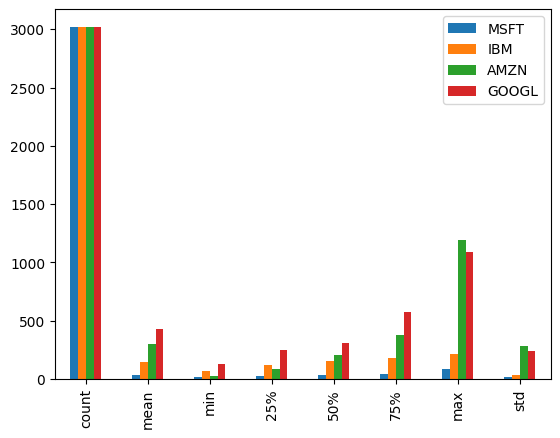

In [ ]:
combined_df.describe().plot(kind='bar')
plt.show()

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [ ]:
# Handle Missing Values

print('Column-wise missing values:\n', '\n', combined_df.isnull().sum()) # Only few missing values --> lets drop them
print(' ')
print('Total number of missing values:',combined_df.isnull().sum().sum())

Column-wise missing values:
 
 Date     0
MSFT     1
IBM      0
AMZN     1
GOOGL    1
dtype: int64
 
Total number of missing values: 3


In [ ]:
# Lets drop the missing values:
combined_df = combined_df.dropna()

In [ ]:
# Dropped all the Missing Values:

print('Column-wise missing values:\n', '\n', combined_df.isnull().sum()) # Only few missing values --> lets drop them
print(' ')
print('Total number of missing values:',combined_df.isnull().sum().sum())

Column-wise missing values:
 
 Date     0
MSFT     0
IBM      0
AMZN     0
GOOGL    0
dtype: int64
 
Total number of missing values: 0


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

In [ ]:
# For this instead of 'Close' we need to use the 'Volume' column to make the combined dataframe. Lets do that first.
# We will follow the same steps. Only difference will be the column name.

# concatenating all the csv files into one dataframe and by date:

def mergedfbydate_volume(files_csv):

    mergeddf = None # empty variable
    for stock in files_csv:
        df = pd.read_csv(stock)

        stock_name = stock.split('_')[0]
        df = df[['Date','Volume']].copy() # using copy since copy enusures returning a new dataframe and not a view
        df.rename(columns={'Volume':stock_name}, inplace=True)

        if mergeddf is None:
            mergeddf = df
        else:
            mergeddf = pd.merge(mergeddf, df, on='Date', how = 'outer')

    # converting date from string to datetime:
    mergeddf['Date'] = pd.to_datetime(mergeddf['Date'])
    # sorting based on date to create sequence later:
    mergeddf = mergeddf.sort_values('Date').reset_index(drop=True)

    return mergeddf

volume_df = mergedfbydate_volume(files_csv)
volume_df = volume_df.dropna()
print(volume_df.head())

        Date         MSFT       IBM       AMZN       GOOGL
0 2006-01-03   79974418.0  11715200  7582127.0  13137450.0
1 2006-01-04   57975661.0   9840600  7440914.0  15292353.0
2 2006-01-05   48247610.0   7213500  5417258.0  10815661.0
3 2006-01-06  100969092.0   8197400  6154285.0  17759521.0
4 2006-01-09   55627836.0   6858200  8945056.0  12795837.0


In [ ]:
volume_df.info() # No null values

<class 'pandas.core.frame.DataFrame'>
Index: 3019 entries, 0 to 3019
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3019 non-null   datetime64[ns]
 1   MSFT    3019 non-null   float64       
 2   IBM     3019 non-null   int64         
 3   AMZN    3019 non-null   float64       
 4   GOOGL   3019 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 141.5 KB


In [ ]:
volume_df.isnull().sum()

Date     0
MSFT     0
IBM      0
AMZN     0
GOOGL    0
dtype: int64

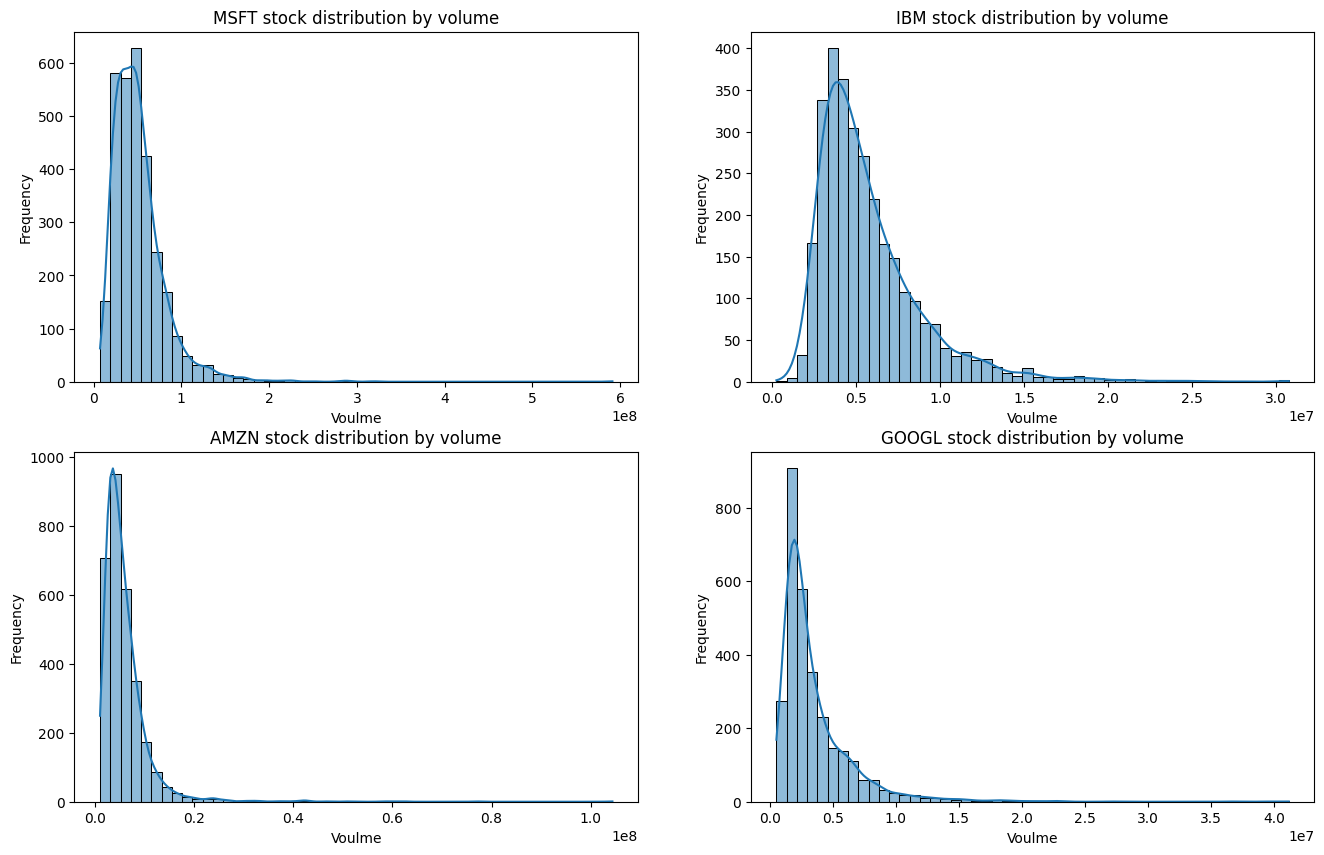

In [ ]:
# Frequency distribution of volumes

plt.figure(figsize=(16,10))
for i,stock in enumerate(volume_df.columns[1:], start=1):
    plt.subplot(2,2,i)
    sns.histplot(volume_df[stock], bins=50, kde=True)
    plt.title(f'{stock} stock distribution by volume')
    plt.xlabel('Voulme')
    plt.ylabel('Frequency')
plt.show()

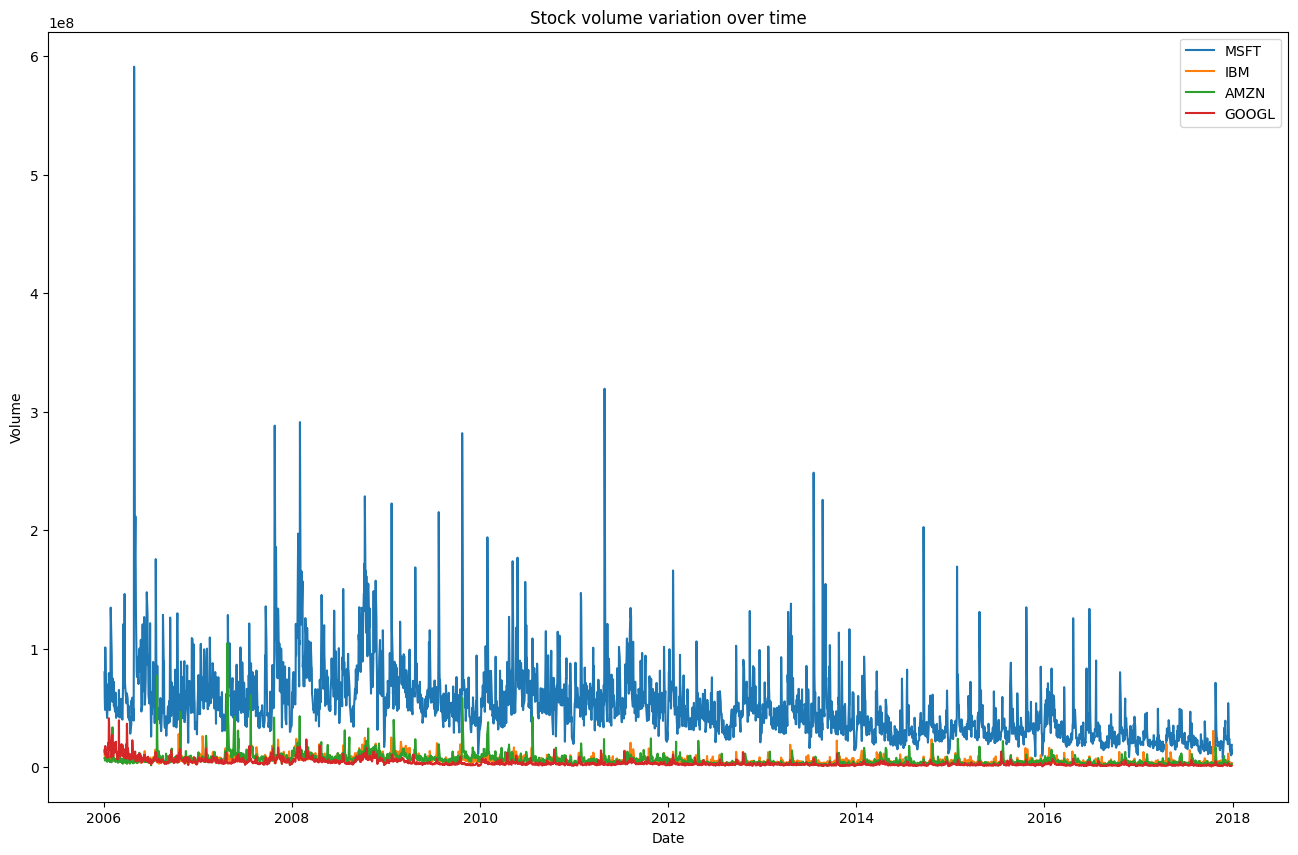

In [ ]:
# Stock volume variation over time

plt.figure(figsize=(16,10))
for stock in volume_df.columns[1:]:
    plt.plot(volume_df['Date'], volume_df[stock], label= stock)
plt.title('Stock volume variation over time')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

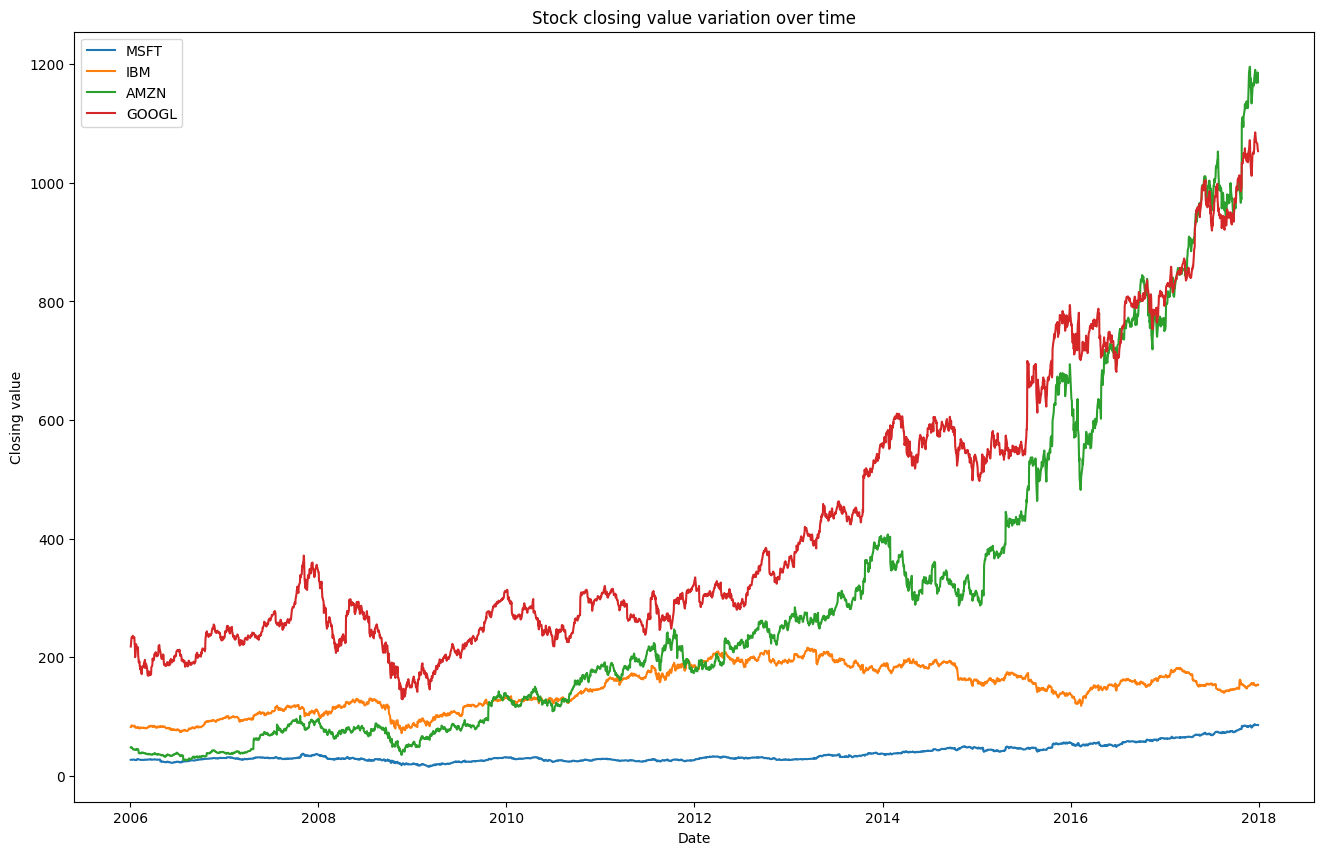

In [ ]:
# Analyse correlations

# Corelating closing values of all the comapnies over time:
plt.figure(figsize=(16,10))
for stock in combined_df.columns[1:]:
    plt.plot(combined_df['Date'], combined_df[stock], label= stock)
plt.title('Stock closing value variation over time')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Closing value')
plt.show()

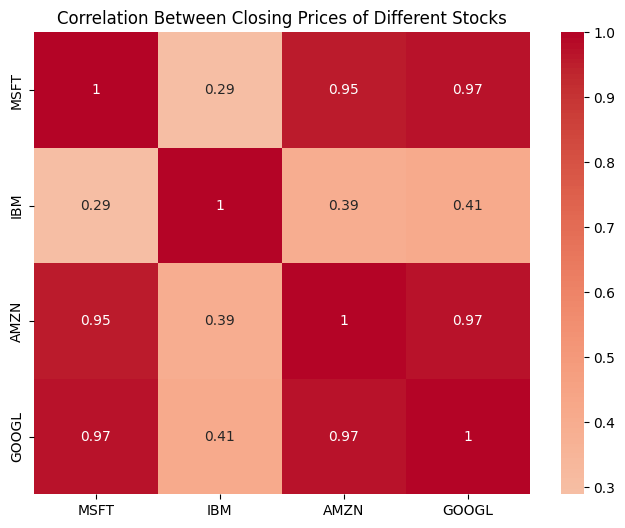

In [ ]:
# Analyzing correlation among the closing values in between the company stocks:

# Drop Date for correlation
corr_matrix = combined_df.drop(columns='Date').corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Closing Prices of Different Stocks')
plt.show()

In [ ]:
# For this instead of 'Close' we need to use the 'Open' column to make the combined dataframe. Lets do that first.
# We will follow the same steps. Only difference will be the column name.

# concatenating all the csv files into one dataframe and by date:

def mergedfbydate_open(files_csv):

    mergeddf = None # empty variable
    for stock in files_csv:
        df = pd.read_csv(stock)

        stock_name = stock.split('_')[0]
        df = df[['Date','Open']].copy() # using copy since copy enusures returning a new dataframe and not a view
        df.rename(columns={'Open':stock_name}, inplace=True)

        if mergeddf is None:
            mergeddf = df
        else:
            mergeddf = pd.merge(mergeddf, df, on='Date', how = 'outer')

    # converting date from string to datetime:
    mergeddf['Date'] = pd.to_datetime(mergeddf['Date'])
    # sorting based on date to create sequence later:
    mergeddf = mergeddf.sort_values('Date').reset_index(drop=True)

    return mergeddf

open_df = mergedfbydate_open(files_csv)
open_df = volume_df.dropna()
print(open_df.head())

        Date         MSFT       IBM       AMZN       GOOGL
0 2006-01-03   79974418.0  11715200  7582127.0  13137450.0
1 2006-01-04   57975661.0   9840600  7440914.0  15292353.0
2 2006-01-05   48247610.0   7213500  5417258.0  10815661.0
3 2006-01-06  100969092.0   8197400  6154285.0  17759521.0
4 2006-01-09   55627836.0   6858200  8945056.0  12795837.0


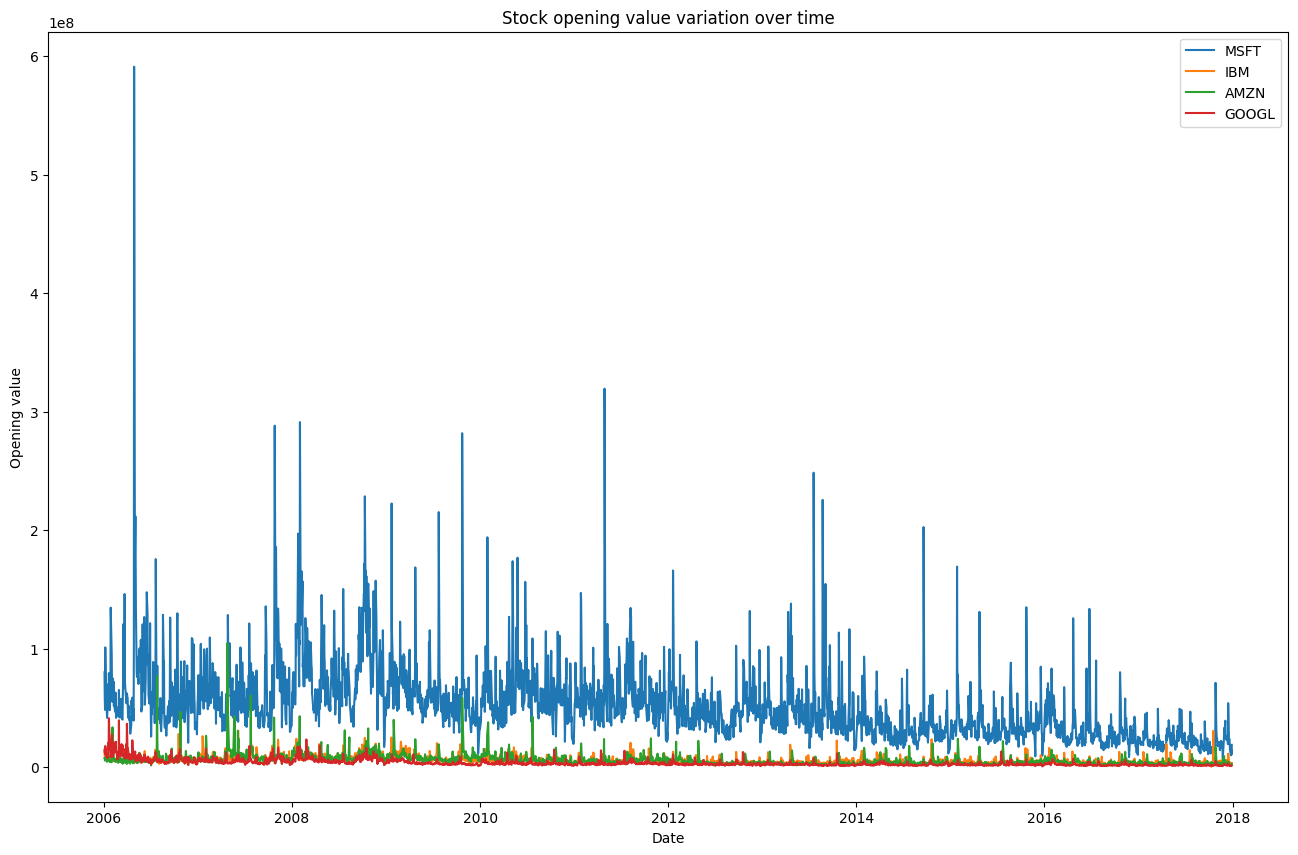

In [ ]:
# Corelating opening values of all the comapnies over time:
plt.figure(figsize=(16,10))
for stock in combined_df.columns[1:]:
    plt.plot(open_df['Date'], open_df[stock], label= stock)
plt.title('Stock opening value variation over time')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Opening value')
plt.show()

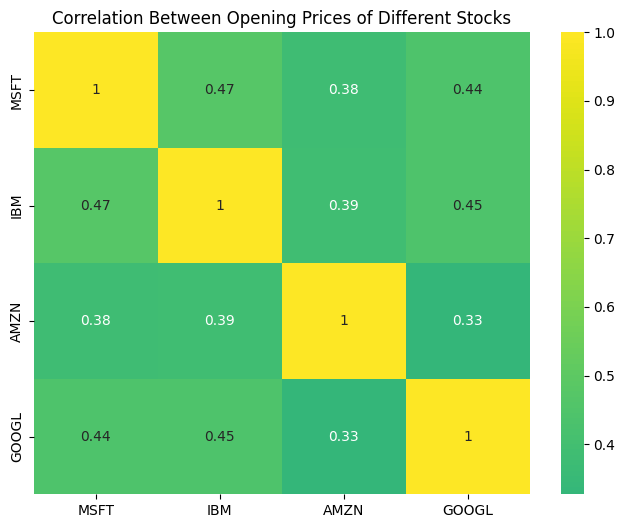

In [ ]:
# Analyzing correlation among the closing values in between the company stocks:

# Drop Date for correlation
corr_matrix = open_df.drop(columns='Date').corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', center=0)
plt.title('Correlation Between Opening Prices of Different Stocks')
plt.show()

In [ ]:
# For this instead of 'Close' we need to use the 'Open' column to make the combined dataframe. Lets do that first.
# We will follow the same steps. Only difference will be the column name.

# concatenating all the csv files into one dataframe and by date:

def mergedfbydate_high(files_csv):

    mergeddf = None # empty variable
    for stock in files_csv:
        df = pd.read_csv(stock)

        stock_name = stock.split('_')[0]
        df = df[['Date','High']].copy() # using copy since copy enusures returning a new dataframe and not a view
        df.rename(columns={'High':stock_name}, inplace=True)

        if mergeddf is None:
            mergeddf = df
        else:
            mergeddf = pd.merge(mergeddf, df, on='Date', how = 'outer')

    # converting date from string to datetime:
    mergeddf['Date'] = pd.to_datetime(mergeddf['Date'])
    # sorting based on date to create sequence later:
    mergeddf = mergeddf.sort_values('Date').reset_index(drop=True)

    return mergeddf

high_df = mergedfbydate_high(files_csv)
high_df = high_df.dropna()
print(high_df.head())

        Date   MSFT    IBM   AMZN   GOOGL
0 2006-01-03  27.00  82.55  47.85  218.05
1 2006-01-04  27.08  82.50  47.73  224.70
2 2006-01-05  27.13  82.90  48.20  226.00
3 2006-01-06  27.00  85.03  48.58  235.49
4 2006-01-09  27.07  84.25  47.10  236.94


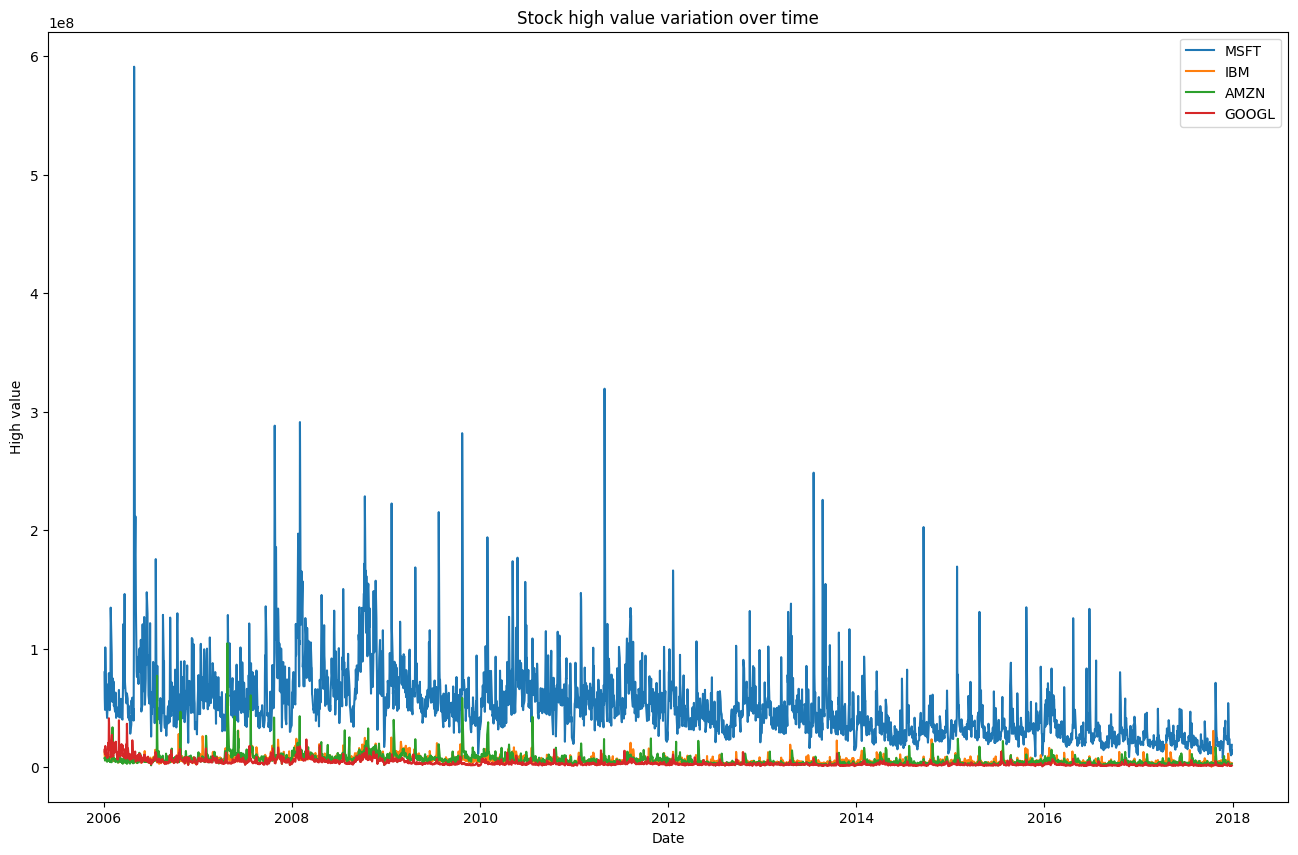

In [ ]:
# Corelating high values of all the comapnies over time:
plt.figure(figsize=(16,10))
for stock in combined_df.columns[1:]:
    plt.plot(open_df['Date'], open_df[stock], label= stock)
plt.title('Stock high value variation over time')
plt.legend()
plt.xlabel('Date')
plt.ylabel('High value')
plt.show()

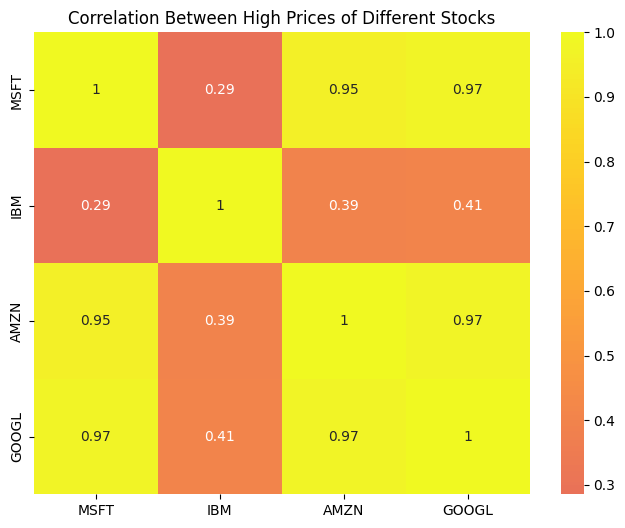

In [ ]:
# Analyzing correlation among the closing values in between the company stocks:

# Drop Date for correlation
corr_matrix = high_df.drop(columns='Date').corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='plasma', center=0)
plt.title('Correlation Between High Prices of Different Stocks')
plt.show()

In [ ]:
# For this instead of 'Close' we need to use the 'Open' column to make the combined dataframe. Lets do that first.
# We will follow the same steps. Only difference will be the column name.

# concatenating all the csv files into one dataframe and by date:

def mergedfbydate_low(files_csv):

    mergeddf = None # empty variable
    for stock in files_csv:
        df = pd.read_csv(stock)

        stock_name = stock.split('_')[0]
        df = df[['Date','Low']].copy() # using copy since copy enusures returning a new dataframe and not a view
        df.rename(columns={'Low':stock_name}, inplace=True)

        if mergeddf is None:
            mergeddf = df
        else:
            mergeddf = pd.merge(mergeddf, df, on='Date', how = 'outer')

    # converting date from string to datetime:
    mergeddf['Date'] = pd.to_datetime(mergeddf['Date'])
    # sorting based on date to create sequence later:
    mergeddf = mergeddf.sort_values('Date').reset_index(drop=True)

    return mergeddf

low_df = mergedfbydate_low(files_csv)
low_df = low_df.dropna()
print(low_df.head())

        Date   MSFT    IBM   AMZN   GOOGL
0 2006-01-03  26.10  80.81  46.25  209.32
1 2006-01-04  26.77  81.33  46.69  220.09
2 2006-01-05  26.91  81.00  47.11  220.97
3 2006-01-06  26.49  83.41  47.32  226.85
4 2006-01-09  26.76  83.38  46.40  230.70


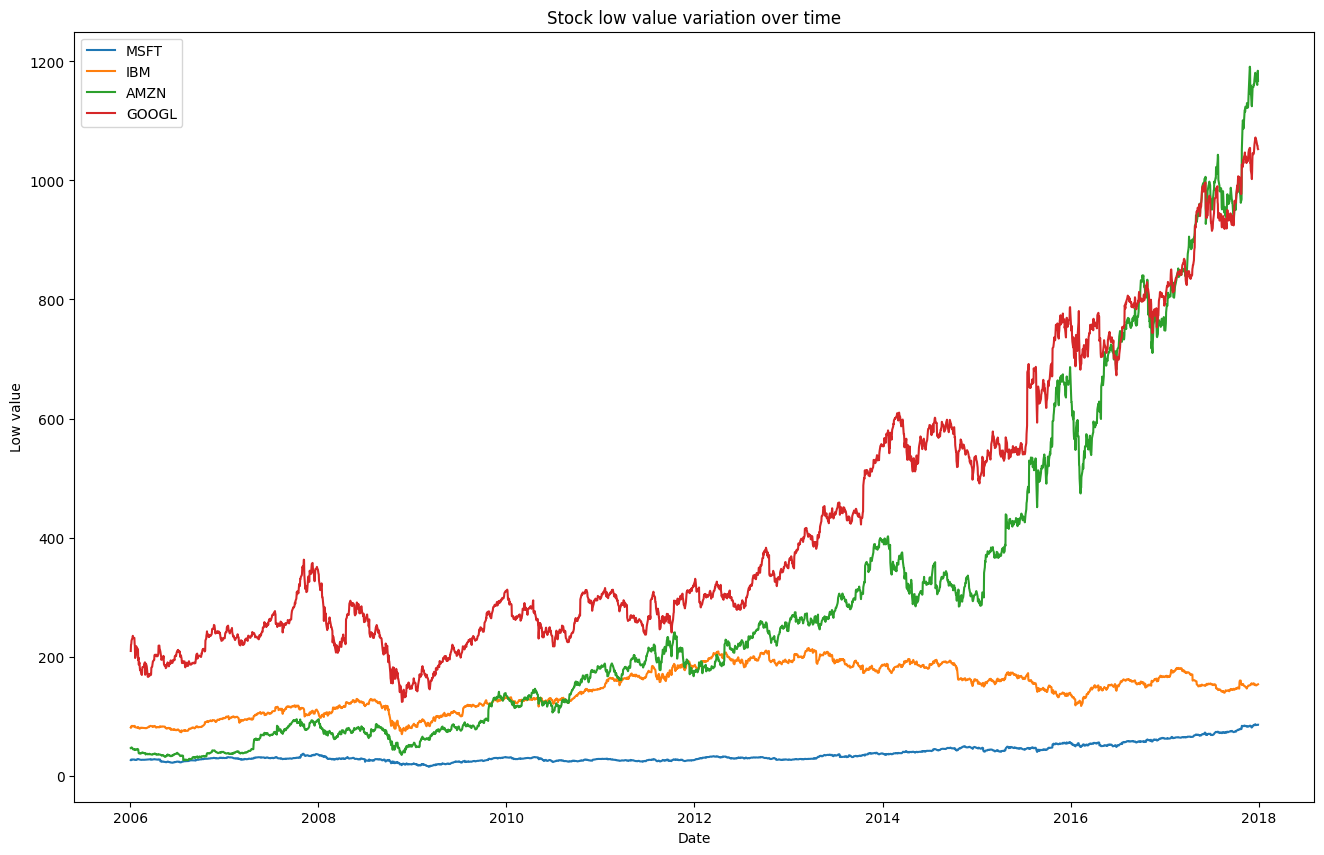

In [ ]:
# Corelating high values of all the comapnies over time:
plt.figure(figsize=(16,10))
for stock in low_df.columns[1:]:
    plt.plot(low_df['Date'], low_df[stock], label= stock)
plt.title('Stock low value variation over time')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Low value')
plt.show()

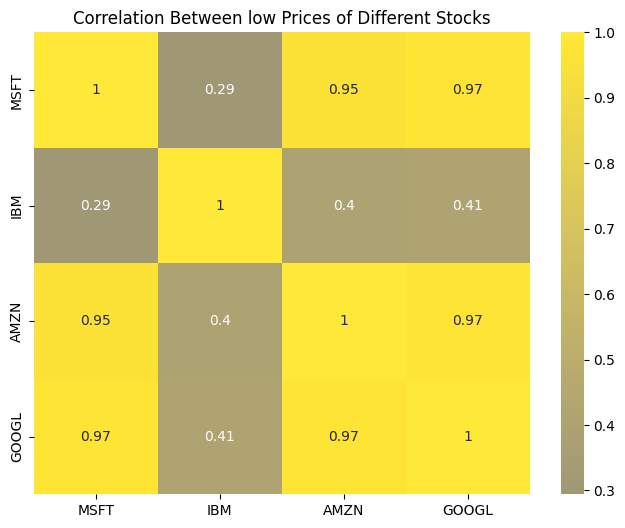

In [ ]:
# Analyzing correlation among the closing values in between the company stocks:

# Drop Date for correlation
corr_matrix = low_df.drop(columns='Date').corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='cividis', center=0)
plt.title('Correlation Between low Prices of Different Stocks')
plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [ ]:
# Define a function that divides the data into windows and generates target variable values for each window
def create_windows(series, window_size=30, horizon=1):
    X, y = [], []
    for i in range(len(series) - window_size - horizon + 1):
        window = series[i : i + window_size]
        target = series[i + window_size : i + window_size + horizon]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [ ]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

from sklearn.preprocessing import MinMaxScaler

def scale_series_partial(series, window_size=30):
    scaler = MinMaxScaler()
    reshaped_series = series.reshape(-1, 1)
    for i in range(len(reshaped_series) - window_size + 1):
        window = reshaped_series[i : i + window_size]
        scaler.partial_fit(window)
    scaled = scaler.transform(reshaped_series).flatten()
    return scaled, scaler

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [ ]:
# Define a function to create input and output data points from the master DataFrame

def split_train_val(X, y, split_ratio=0.8):
    split_index = int(len(X) * split_ratio)
    X_train, y_train = X[:split_index], y[:split_index]
    X_val, y_val = X[split_index:], y[split_index:]
    return X_train, y_train, X_val, y_val

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [ ]:
# Checking for patterns in different sequence lengths

# Plot segments of a stock time series by month ('M'), week ('W'), or quarter ('Q').
# Helps visualize trends and identify a good window size.

def plot_by_time_slices(df, stock_name, freq='M'):
    df_temp = df[['Date', stock_name]].copy()
    df_temp['Date'] = pd.to_datetime(df_temp['Date'])
    df_temp.set_index('Date', inplace=True)
    grouped = df_temp.groupby(pd.Grouper(freq=freq))

    plt.figure(figsize=(14, 6))
    for i, (name, group) in enumerate(grouped):
        plt.plot(group.index, group[stock_name], label=str(name.date()))
    plt.title(f"{stock_name} by {freq} slices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    #plt.legend(loc='upper right', fontsize='small', ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


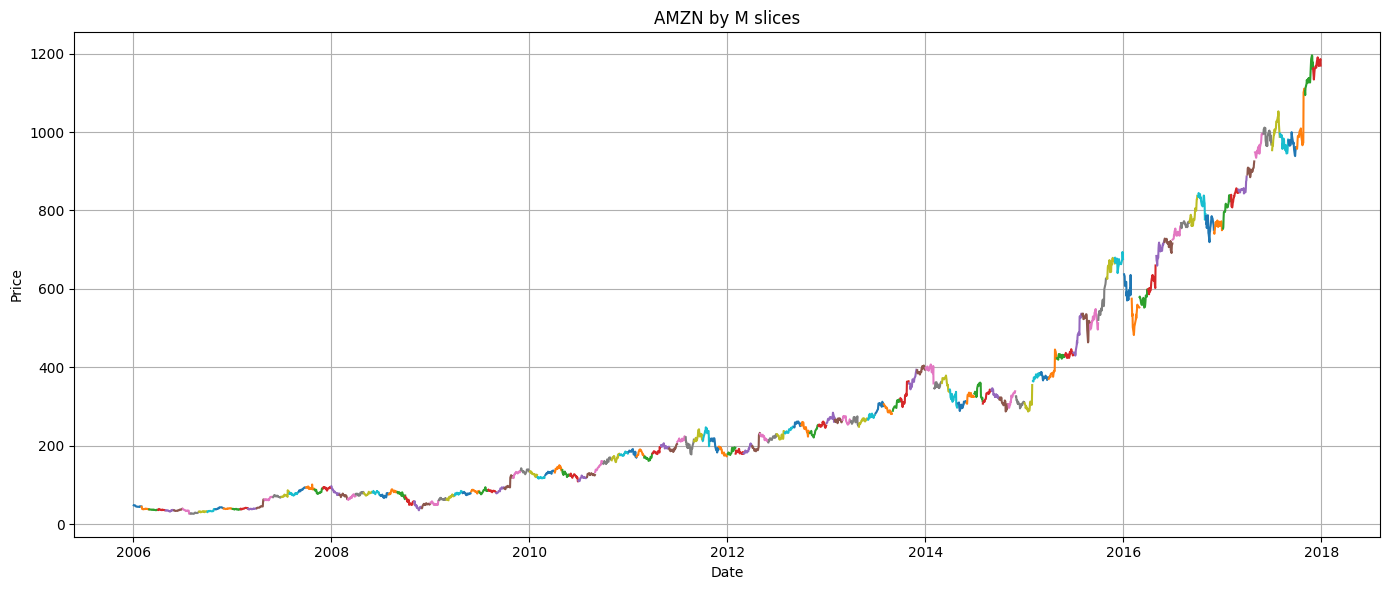

In [ ]:
plot_by_time_slices(combined_df, 'AMZN', 'M')

In [ ]:
# Lets take a window size of 30 days. 30 time steps --> since each observation is on next day.

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [ ]:
# Create data instances from the master data frame using decided window size and window stride

def prepare_stock_data(df, stock_name, window_size=30, horizon=1):
    series = df[stock_name].values.astype(np.float32)
    scaled_series, scaler = scale_series_partial(series, window_size)
    X, y = create_windows(scaled_series, window_size, horizon)
    return split_train_val(X, y), scaler

In [ ]:
# Check the number of data points generated

# Will do this individually after creating model for each stock.

**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [ ]:
# Check if the datasets are compatible inputs to neural networks

# Will do this individually after creating model for each stock.

## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [ ]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def build_simple_rnn(window_size, horizon):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import SimpleRNN, Dense

    model = Sequential([
        SimpleRNN(32, input_shape=(window_size, 1)),
        Dense(horizon)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

Epoch 1/20
75/75 [==============================] - 3s 21ms/step - loss: 0.0035 - val_loss: 0.0125
Epoch 2/20
75/75 [==============================] - 1s 18ms/step - loss: 9.7804e-04 - val_loss: 0.0030
Epoch 3/20
75/75 [==============================] - 1s 19ms/step - loss: 8.3887e-04 - val_loss: 0.0039
Epoch 4/20
75/75 [==============================] - 1s 18ms/step - loss: 6.1975e-04 - val_loss: 0.0019
Epoch 5/20
75/75 [==============================] - 1s 17ms/step - loss: 5.5574e-04 - val_loss: 0.0018
Epoch 6/20
75/75 [==============================] - 1s 16ms/step - loss: 4.9172e-04 - val_loss: 8.3875e-04
Epoch 7/20
75/75 [==============================] - 1s 18ms/step - loss: 4.5901e-04 - val_loss: 0.0020
Epoch 8/20
75/75 [==============================] - 1s 17ms/step - loss: 4.4886e-04 - val_loss: 3.5347e-04
Epoch 9/20
75/75 [==============================] - 1s 18ms/step - loss: 4.0098e-04 - val_loss: 4.6718e-04
Epoch 10/20
75/75 [==============================] - 1s 19ms/step

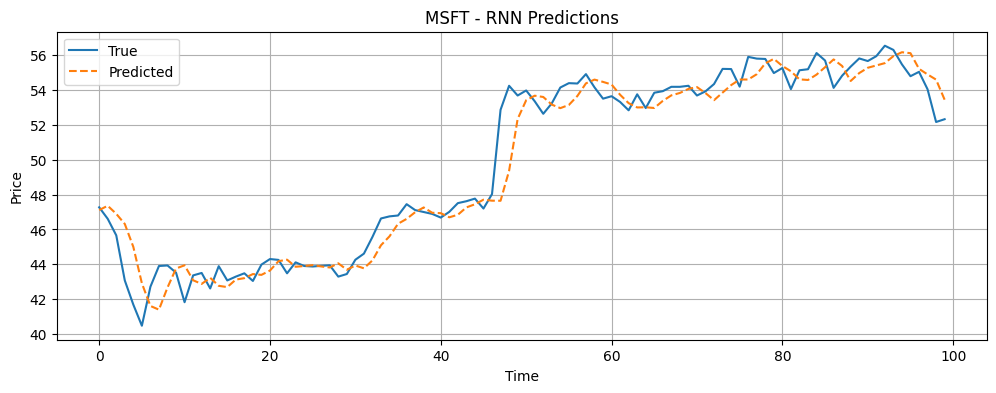

In [ ]:
# 0. Setup: Choose parameters and stock
stock_name = 'MSFT'
window_size = 30
forecast_horizon = 1

# 1. Plot the raw series
# plot_series(combined_df[stock_name], stock_name)

# 2. Prepare the data (scaling + windowing + split)
(X_train, y_train, X_val, y_val), scaler = prepare_stock_data(combined_df, stock_name, window_size, forecast_horizon)

# 3. Reshape X for RNN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)

# 4. Build the model
model = build_advanced_rnn(window_size, forecast_horizon, model_type='SimpleRNN', units=64)
# Save the model to disk
model.save("RNN_MSFT.h5")

# 5. Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# 6. Predict on validation set
y_pred = model.predict(X_val)

# 7. Inverse scale predictions and ground truth
y_val_inv = scaler.inverse_transform(y_val)
y_pred_inv = scaler.inverse_transform(y_pred)

# 8. Plot predictions vs true values
plt.figure(figsize=(12, 4))
plt.plot(y_val_inv[:100], label='True')
plt.plot(y_pred_inv[:100], label='Predicted', linestyle='--')
plt.title(f'{stock_name} - RNN Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/20
75/75 [==============================] - 2s 18ms/step - loss: 0.0140 - val_loss: 8.5833e-04
Epoch 2/20
75/75 [==============================] - 1s 18ms/step - loss: 0.0042 - val_loss: 7.5672e-04
Epoch 3/20
75/75 [==============================] - 2s 20ms/step - loss: 0.0040 - val_loss: 8.1651e-04
Epoch 4/20
75/75 [==============================] - 1s 18ms/step - loss: 0.0028 - val_loss: 5.0155e-04
Epoch 5/20
75/75 [==============================] - 1s 19ms/step - loss: 0.0024 - val_loss: 2.9259e-04
Epoch 6/20
75/75 [==============================] - 1s 19ms/step - loss: 0.0022 - val_loss: 2.8185e-04
Epoch 7/20
75/75 [==============================] - 2s 20ms/step - loss: 0.0024 - val_loss: 2.7250e-04
Epoch 8/20
75/75 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 3.7433e-04
Epoch 9/20
75/75 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 3.4698e-04
Epoch 10/20
75/75 [==============================] - 1s 17ms/step - loss:

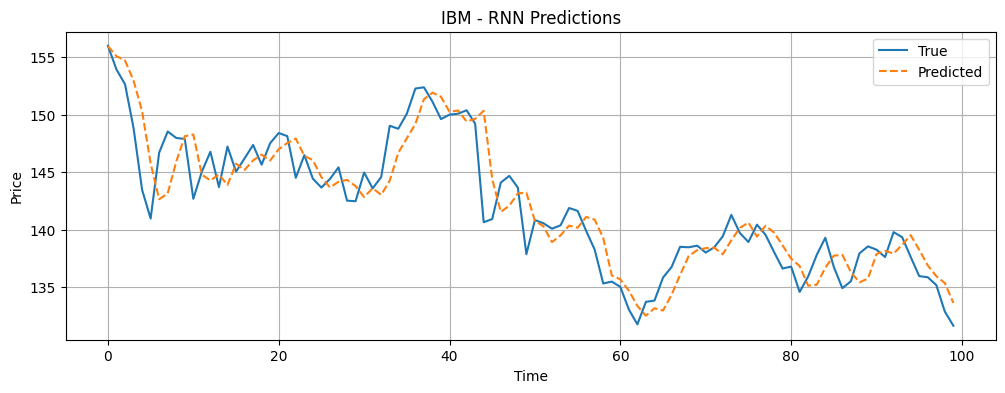

In [ ]:
# 0. Setup: Choose parameters and stock
stock_name = 'IBM'
window_size = 30
forecast_horizon = 1

# 1. Plot the raw series
# plot_series(combined_df[stock_name], stock_name)

# 2. Prepare the data (scaling + windowing + split)
(X_train, y_train, X_val, y_val), scaler = prepare_stock_data(combined_df, stock_name, window_size, forecast_horizon)

# 3. Reshape X for RNN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)

# 4. Build the model
model = build_advanced_rnn(window_size, forecast_horizon, model_type='SimpleRNN', units=64)
# Save the model to disk
model.save("RNN_IBM.h5")

# 5. Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# 6. Predict on validation set
y_pred = model.predict(X_val)

# 7. Inverse scale predictions and ground truth
y_val_inv = scaler.inverse_transform(y_val)
y_pred_inv = scaler.inverse_transform(y_pred)

# 8. Plot predictions vs true values
plt.figure(figsize=(12, 4))
plt.plot(y_val_inv[:100], label='True')
plt.plot(y_pred_inv[:100], label='Predicted', linestyle='--')
plt.title(f'{stock_name} - RNN Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/20
75/75 [==============================] - 3s 20ms/step - loss: 0.0040 - val_loss: 0.0131
Epoch 2/20
75/75 [==============================] - 1s 18ms/step - loss: 9.6349e-04 - val_loss: 0.0089
Epoch 3/20
75/75 [==============================] - 1s 17ms/step - loss: 7.3821e-04 - val_loss: 0.0030
Epoch 4/20
75/75 [==============================] - 1s 18ms/step - loss: 6.5341e-04 - val_loss: 0.0035
Epoch 5/20
75/75 [==============================] - 1s 16ms/step - loss: 6.0011e-04 - val_loss: 0.0034
Epoch 6/20
75/75 [==============================] - 1s 18ms/step - loss: 4.7974e-04 - val_loss: 7.1652e-04
Epoch 7/20
75/75 [==============================] - 1s 19ms/step - loss: 5.0545e-04 - val_loss: 6.2896e-04
Epoch 8/20
75/75 [==============================] - 1s 19ms/step - loss: 4.7446e-04 - val_loss: 4.5224e-04
Epoch 9/20
75/75 [==============================] - 1s 19ms/step - loss: 4.3030e-04 - val_loss: 0.0038
Epoch 10/20
75/75 [==============================] - 1s 19ms/step

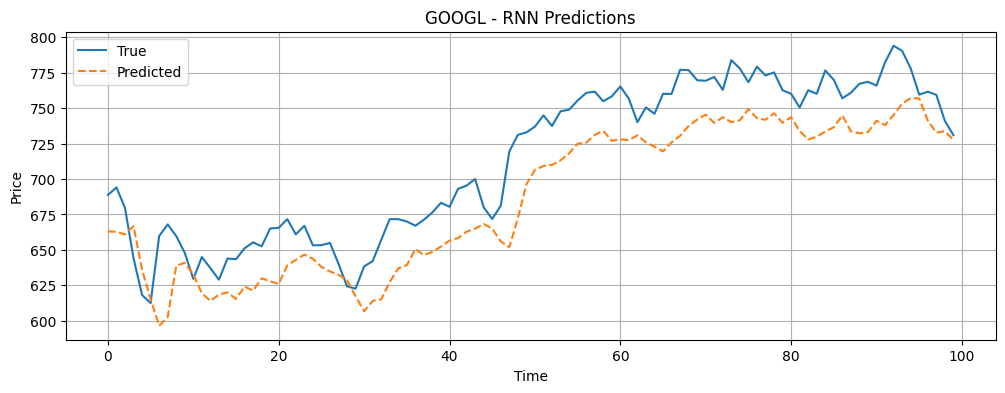

In [ ]:
# 0. Setup: Choose parameters and stock
stock_name = 'GOOGL'
window_size = 30
forecast_horizon = 1

# 1. Plot the raw series
# plot_series(combined_df[stock_name], stock_name)

# 2. Prepare the data (scaling + windowing + split)
(X_train, y_train, X_val, y_val), scaler = prepare_stock_data(combined_df, stock_name, window_size, forecast_horizon)

# 3. Reshape X for RNN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)

# 4. Build the model
model = build_advanced_rnn(window_size, forecast_horizon, model_type='SimpleRNN', units=64)
# Save the model to disk
model.save("RNN_GOOGL.h5")

# 5. Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# 6. Predict on validation set
y_pred = model.predict(X_val)

# 7. Inverse scale predictions and ground truth
y_val_inv = scaler.inverse_transform(y_val)
y_pred_inv = scaler.inverse_transform(y_pred)

# 8. Plot predictions vs true values
plt.figure(figsize=(12, 4))
plt.plot(y_val_inv[:100], label='True')
plt.plot(y_pred_inv[:100], label='Predicted', linestyle='--')
plt.title(f'{stock_name} - RNN Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/20
75/75 [==============================] - 3s 20ms/step - loss: 0.0034 - val_loss: 0.0127
Epoch 2/20
75/75 [==============================] - 1s 17ms/step - loss: 5.1345e-04 - val_loss: 0.0066
Epoch 3/20
75/75 [==============================] - 1s 19ms/step - loss: 3.6971e-04 - val_loss: 0.0037
Epoch 4/20
75/75 [==============================] - 1s 20ms/step - loss: 3.4119e-04 - val_loss: 0.0059
Epoch 5/20
75/75 [==============================] - 2s 21ms/step - loss: 2.6474e-04 - val_loss: 0.0022
Epoch 6/20
75/75 [==============================] - 1s 18ms/step - loss: 2.4449e-04 - val_loss: 0.0015
Epoch 7/20
75/75 [==============================] - 1s 18ms/step - loss: 2.0948e-04 - val_loss: 0.0012
Epoch 8/20
75/75 [==============================] - 1s 18ms/step - loss: 1.9226e-04 - val_loss: 0.0021
Epoch 9/20
75/75 [==============================] - 1s 18ms/step - loss: 1.8434e-04 - val_loss: 8.4088e-04
Epoch 10/20
75/75 [==============================] - 1s 18ms/step - loss:

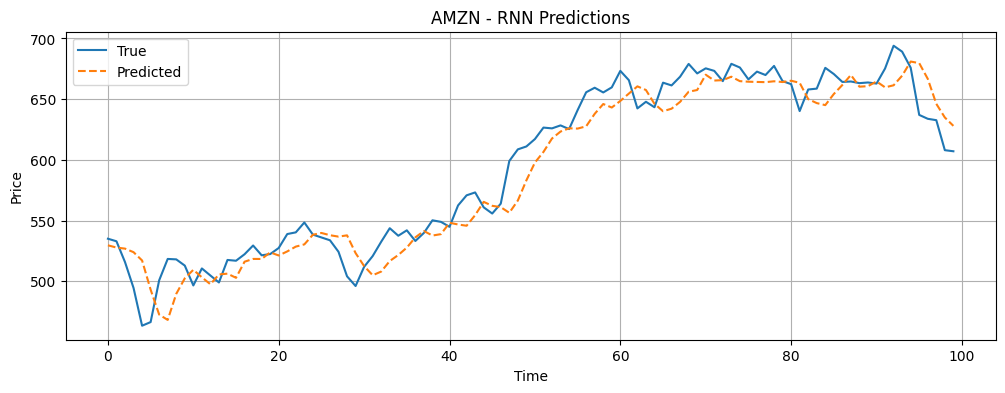

In [ ]:
# 0. Setup: Choose parameters and stock
stock_name = 'AMZN'
window_size = 30
forecast_horizon = 1

# 1. Plot the raw series
# plot_series(combined_df[stock_name], stock_name)

# 2. Prepare the data (scaling + windowing + split)
(X_train, y_train, X_val, y_val), scaler = prepare_stock_data(combined_df, stock_name, window_size, forecast_horizon)

# 3. Reshape X for RNN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)

# 4. Build the model
model = build_advanced_rnn(window_size, forecast_horizon, model_type='SimpleRNN', units=64)
# Save the model to disk
model.save("RNN_AMZN.h5")

# 5. Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# 6. Predict on validation set
y_pred = model.predict(X_val)

# 7. Inverse scale predictions and ground truth
y_val_inv = scaler.inverse_transform(y_val)
y_pred_inv = scaler.inverse_transform(y_pred)

# 8. Plot predictions vs true values
plt.figure(figsize=(12, 4))
plt.plot(y_val_inv[:100], label='True')
plt.plot(y_pred_inv[:100], label='Predicted', linestyle='--')
plt.title(f'{stock_name} - RNN Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/20
75/75 [==============================] - 3s 13ms/step - loss: 0.0053 - val_loss: 8.5827e-04
Epoch 2/20
75/75 [==============================] - 0s 6ms/step - loss: 6.2176e-04 - val_loss: 6.4370e-04
Epoch 3/20
75/75 [==============================] - 0s 6ms/step - loss: 5.3141e-04 - val_loss: 0.0014
Epoch 4/20
75/75 [==============================] - 0s 6ms/step - loss: 5.0028e-04 - val_loss: 9.9489e-04
Epoch 5/20
75/75 [==============================] - 0s 6ms/step - loss: 4.5178e-04 - val_loss: 0.0016
Epoch 6/20
75/75 [==============================] - 0s 6ms/step - loss: 4.3551e-04 - val_loss: 9.4903e-04
Epoch 7/20
75/75 [==============================] - 0s 6ms/step - loss: 3.8635e-04 - val_loss: 5.6800e-04
Epoch 8/20
75/75 [==============================] - 0s 6ms/step - loss: 3.8559e-04 - val_loss: 3.9272e-04
Epoch 9/20
75/75 [==============================] - 0s 7ms/step - loss: 3.6797e-04 - val_loss: 7.3850e-04
Epoch 10/20
75/75 [==============================] - 0s 7

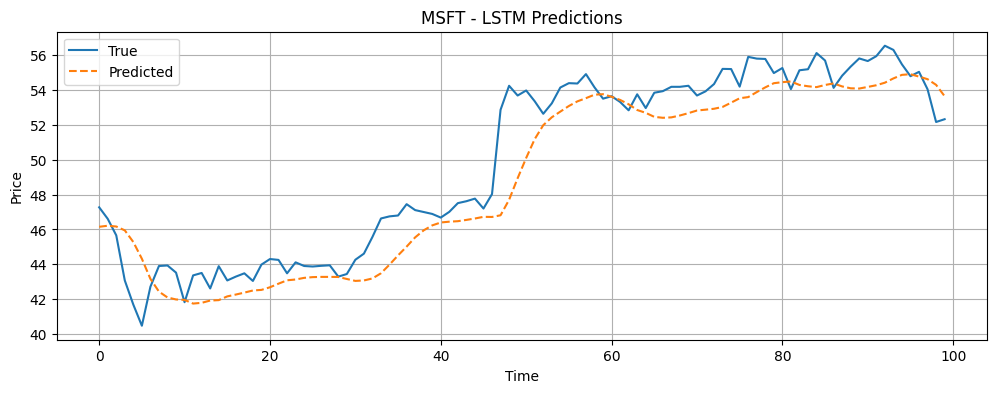

In [ ]:
# 0. Setup: Choose parameters and stock
stock_name = 'MSFT'
window_size = 30
forecast_horizon = 1

# 1. Plot the raw series
# plot_series(combined_df[stock_name], stock_name)

# 2. Prepare the data (scaling + windowing + split)
(X_train, y_train, X_val, y_val), scaler = prepare_stock_data(combined_df, stock_name, window_size, forecast_horizon)

# 3. Reshape X for RNN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)

# 4. Build the model
model = build_advanced_rnn(window_size, forecast_horizon, model_type='LSTM', units=64)
# Save the model to disk
model.save("model_MSFT.h5")

# 5. Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# 6. Predict on validation set
y_pred = model.predict(X_val)

# 7. Inverse scale predictions and ground truth
y_val_inv = scaler.inverse_transform(y_val)
y_pred_inv = scaler.inverse_transform(y_pred)

# 8. Plot predictions vs true values
plt.figure(figsize=(12, 4))
plt.plot(y_val_inv[:100], label='True')
plt.plot(y_pred_inv[:100], label='Predicted', linestyle='--')
plt.title(f'{stock_name} - LSTM Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/20
75/75 [==============================] - 3s 18ms/step - loss: 0.0232 - val_loss: 5.8877e-04
Epoch 2/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0033 - val_loss: 5.3086e-04
Epoch 3/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0029 - val_loss: 8.6194e-04
Epoch 4/20
75/75 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 5/20
75/75 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 4.7076e-04
Epoch 6/20
75/75 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 5.8784e-04
Epoch 7/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 4.4021e-04
Epoch 8/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 4.2899e-04
Epoch 9/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 10/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0019 - val_los

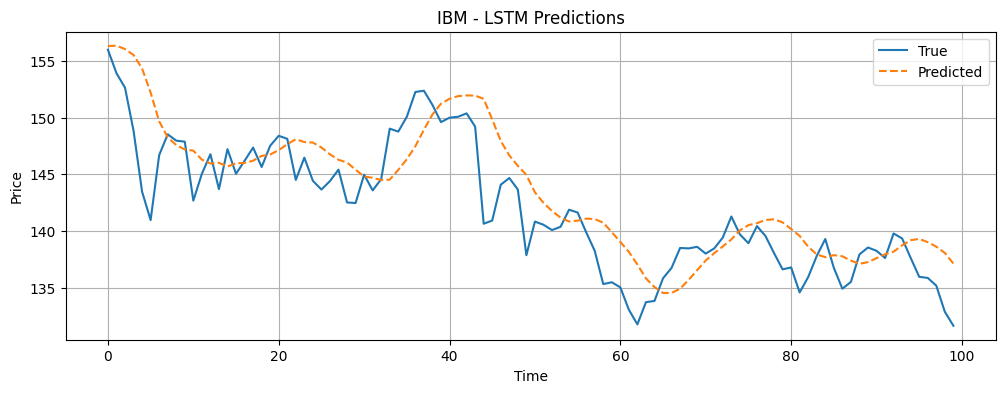

In [ ]:
# 0. Setup: Choose parameters and stock
stock_name = 'IBM'
window_size = 30
forecast_horizon = 1

# 1. Plot the raw series
# plot_series(combined_df[stock_name], stock_name)

# 2. Prepare the data (scaling + windowing + split)
(X_train, y_train, X_val, y_val), scaler = prepare_stock_data(combined_df, stock_name, window_size, forecast_horizon)

# 3. Reshape X for RNN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)

# 4. Build the model
model = build_advanced_rnn(window_size, forecast_horizon, model_type='LSTM', units=64)
# Save the model to disk
model.save("model_IBM.h5")

# 5. Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# 6. Predict on validation set
y_pred = model.predict(X_val)

# 7. Inverse scale predictions and ground truth
y_val_inv = scaler.inverse_transform(y_val)
y_pred_inv = scaler.inverse_transform(y_pred)

# 8. Plot predictions vs true values
plt.figure(figsize=(12, 4))
plt.plot(y_val_inv[:100], label='True')
plt.plot(y_pred_inv[:100], label='Predicted', linestyle='--')
plt.title(f'{stock_name} - LSTM Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/20
75/75 [==============================] - 3s 13ms/step - loss: 0.0089 - val_loss: 0.0039
Epoch 2/20
75/75 [==============================] - 1s 8ms/step - loss: 8.8645e-04 - val_loss: 0.0011
Epoch 3/20
75/75 [==============================] - 1s 7ms/step - loss: 6.6579e-04 - val_loss: 0.0018
Epoch 4/20
75/75 [==============================] - 1s 7ms/step - loss: 6.5302e-04 - val_loss: 0.0028
Epoch 5/20
75/75 [==============================] - 1s 7ms/step - loss: 6.2544e-04 - val_loss: 7.2856e-04
Epoch 6/20
75/75 [==============================] - 1s 7ms/step - loss: 5.3413e-04 - val_loss: 5.5344e-04
Epoch 7/20
75/75 [==============================] - 0s 6ms/step - loss: 4.9394e-04 - val_loss: 4.5807e-04
Epoch 8/20
75/75 [==============================] - 0s 6ms/step - loss: 4.6759e-04 - val_loss: 4.7779e-04
Epoch 9/20
75/75 [==============================] - 0s 7ms/step - loss: 4.2162e-04 - val_loss: 4.2141e-04
Epoch 10/20
75/75 [==============================] - 1s 7ms/step 

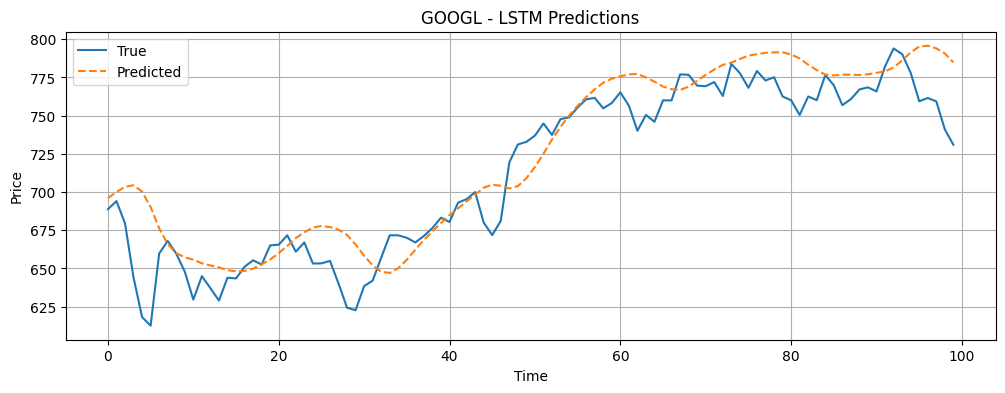

In [ ]:
# 0. Setup: Choose parameters and stock
stock_name = 'GOOGL'
window_size = 30
forecast_horizon = 1

# 1. Plot the raw series
# plot_series(combined_df[stock_name], stock_name)

# 2. Prepare the data (scaling + windowing + split)
(X_train, y_train, X_val, y_val), scaler = prepare_stock_data(combined_df, stock_name, window_size, forecast_horizon)

# 3. Reshape X for RNN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)

# 4. Build the model
model = build_advanced_rnn(window_size, forecast_horizon, model_type='LSTM', units=64)
# Save the model to disk
model.save("model_GOOGL.h5")

# 5. Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# 6. Predict on validation set
y_pred = model.predict(X_val)

# 7. Inverse scale predictions and ground truth
y_val_inv = scaler.inverse_transform(y_val)
y_pred_inv = scaler.inverse_transform(y_pred)

# 8. Plot predictions vs true values
plt.figure(figsize=(12, 4))
plt.plot(y_val_inv[:100], label='True')
plt.plot(y_pred_inv[:100], label='Predicted', linestyle='--')
plt.title(f'{stock_name} - LSTM Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/20
75/75 [==============================] - 3s 13ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 2/20
75/75 [==============================] - 1s 8ms/step - loss: 2.7472e-04 - val_loss: 0.0016
Epoch 3/20
75/75 [==============================] - 1s 8ms/step - loss: 2.3441e-04 - val_loss: 6.6551e-04
Epoch 4/20
75/75 [==============================] - 1s 7ms/step - loss: 2.2028e-04 - val_loss: 5.7456e-04
Epoch 5/20
75/75 [==============================] - 1s 7ms/step - loss: 1.9831e-04 - val_loss: 4.3641e-04
Epoch 6/20
75/75 [==============================] - 0s 7ms/step - loss: 1.7834e-04 - val_loss: 4.2850e-04
Epoch 7/20
75/75 [==============================] - 1s 7ms/step - loss: 1.7086e-04 - val_loss: 3.5723e-04
Epoch 8/20
75/75 [==============================] - 0s 6ms/step - loss: 1.6118e-04 - val_loss: 4.8543e-04
Epoch 9/20
75/75 [==============================] - 0s 6ms/step - loss: 1.4806e-04 - val_loss: 3.5008e-04
Epoch 10/20
75/75 [==============================] - 0s 7

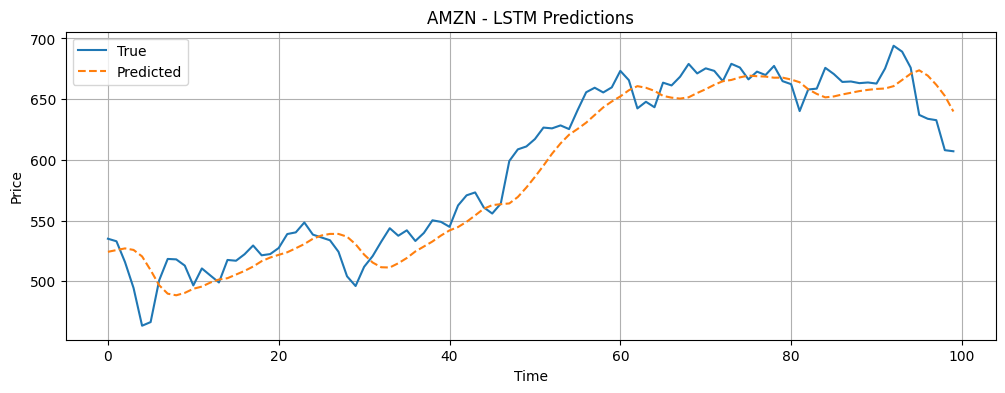

In [ ]:
# 0. Setup: Choose parameters and stock
stock_name = 'AMZN'
window_size = 30
forecast_horizon = 1

# 1. Plot the raw series
# plot_series(combined_df[stock_name], stock_name)

# 2. Prepare the data (scaling + windowing + split)
(X_train, y_train, X_val, y_val), scaler = prepare_stock_data(combined_df, stock_name, window_size, forecast_horizon)

# 3. Reshape X for RNN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)

# 4. Build the model
model = build_advanced_rnn(window_size, forecast_horizon, model_type='LSTM', units=64)
# Save the model to disk
model.save("model_AMZN.h5")

# 5. Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# 6. Predict on validation set
y_pred = model.predict(X_val)

# 7. Inverse scale predictions and ground truth
y_val_inv = scaler.inverse_transform(y_val)
y_pred_inv = scaler.inverse_transform(y_pred)

# 8. Plot predictions vs true values
plt.figure(figsize=(12, 4))
plt.plot(y_val_inv[:100], label='True')
plt.plot(y_pred_inv[:100], label='Predicted', linestyle='--')
plt.title(f'{stock_name} - LSTM Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration of simple RNN

# Lets use keras tuner for hyperparameter tunning:

!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00 0:00:01


In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout

def model_builder(hp, model_type='LSTM'):
    model = Sequential()

    units = hp.Int("units", min_value=32, max_value=128, step=32)
    dropout = hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1)

    if model_type == 'LSTM':
        model.add(LSTM(units, input_shape=(window_size, 1)))
    elif model_type == 'GRU':
        model.add(GRU(units, input_shape=(window_size, 1)))
    elif model_type == 'SimpleRNN':
        model.add(SimpleRNN(units, input_shape=(window_size, 1)))
    else:
        raise ValueError("Invalid model_type")

    model.add(Dropout(dropout))
    model.add(Dense(forecast_horizon))

    model.compile(optimizer='adam', loss='mse')
    return model


In [ ]:
tuner = kt.RandomSearch(
    lambda hp: model_builder(hp, model_type='SimpleRNN'),  # or 'LSTM', 'SimpleRNN'
    objective="val_loss",
    max_trials=5,
    executions_per_trial=1,
    directory="tuner_logs",
    project_name="tune_rnn_msft"
)

# Train with your preprocessed data

# For MSFT
(X_train, y_train, X_val, y_val), scaler = prepare_stock_data(combined_df, "MSFT", 30, 1)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Trial 5 Complete [00h 00m 17s]
val_loss: 0.0002395690098637715

Best val_loss So Far: 0.00020921113900840282
Total elapsed time: 00h 01m 29s


In [ ]:
# Find the best configuration based on evaluation metrics

best_model = tuner.get_best_models(1)[0]
best_model.summary()

# Optionally save it
best_model.save("best_RNN_MSFT.h5")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4289 (16.75 KB)
Trainable params: 4289 (16.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tuner = kt.RandomSearch(
    lambda hp: model_builder(hp, model_type='SimpleRNN'),  # or 'LSTM', 'SimpleRNN'
    objective="val_loss",
    max_trials=5,
    executions_per_trial=1,
    directory="tuner_logs",
    project_name="tune_rnn_IBM"
)

# Train with your preprocessed data

# For IBM
(X_train, y_train, X_val, y_val), scaler = prepare_stock_data(combined_df, "IBM", 30, 1)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Trial 5 Complete [00h 00m 17s]
val_loss: 0.00030199813772924244

Best val_loss So Far: 0.00020435600890778005
Total elapsed time: 00h 01m 28s


In [ ]:
# Find the best configuration based on evaluation metrics

best_model = tuner.get_best_models(1)[0]
best_model.summary()

# Optionally save it
best_model.save("best_RNN_IBM.h5")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 96)                9408      
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 9505 (37.13 KB)
Trainable params: 9505 (37.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# For RNN_IBM
tuner.results_summary()

Results summary
Results in tuner_logs/tune_rnn_IBM
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
units: 96
dropout: 0.30000000000000004
Score: 0.00020435600890778005

Trial 0 summary
Hyperparameters:
units: 128
dropout: 0.30000000000000004
Score: 0.000279885483905673

Trial 4 summary
Hyperparameters:
units: 96
dropout: 0.5
Score: 0.00030199813772924244

Trial 3 summary
Hyperparameters:
units: 32
dropout: 0.30000000000000004
Score: 0.000399838259909302

Trial 1 summary
Hyperparameters:
units: 96
dropout: 0.1
Score: 0.0006289858720265329


In [ ]:
# Similarly other models can also be tunned using 'keras tunner'

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

from tensorflow.keras.models import load_model

model = load_model("best_RNN_MSFT.h5")
(X_train, y_train, X_val, y_val), scaler = prepare_stock_data(combined_df, "MSFT", window_size=30, horizon=1)
y_pred = model.predict(X_val)


Plotting the actual vs predicted values

In [ ]:
# Predict on the test data and plot



It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [ ]:
# Compute the performance of the model on the testing data set



### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [ ]:
# # Define a function to create a model and specify default values for hyperparameters

def build_advanced_rnn(window_size, horizon, model_type='LSTM', units=64, dropout=0.2):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout

    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(units, input_shape=(window_size, 1)))
    elif model_type == 'GRU':
        model.add(GRU(units, input_shape=(window_size, 1)))
    elif model_type == 'SimpleRNN':
        model.add(SimpleRNN(units, input_shape=(window_size, 1)))
    else:
        raise ValueError("Unsupported model_type. Choose from 'LSTM', 'GRU', 'SimpleRNN'")

    model.add(Dropout(dropout))
    model.add(Dense(horizon))
    model.compile(optimizer='adam', loss='mse')
    return model

Epoch 1/20
75/75 [==============================] - 3s 12ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 2/20
75/75 [==============================] - 0s 6ms/step - loss: 5.4455e-04 - val_loss: 2.3135e-04
Epoch 3/20
75/75 [==============================] - 0s 6ms/step - loss: 4.8266e-04 - val_loss: 2.1800e-04
Epoch 4/20
75/75 [==============================] - 0s 6ms/step - loss: 4.1692e-04 - val_loss: 2.4075e-04
Epoch 5/20
75/75 [==============================] - 0s 6ms/step - loss: 3.9403e-04 - val_loss: 2.2906e-04
Epoch 6/20
75/75 [==============================] - 0s 6ms/step - loss: 3.6288e-04 - val_loss: 1.8952e-04
Epoch 7/20
75/75 [==============================] - 0s 6ms/step - loss: 3.2425e-04 - val_loss: 1.9242e-04
Epoch 8/20
75/75 [==============================] - 0s 6ms/step - loss: 3.2491e-04 - val_loss: 2.2313e-04
Epoch 9/20
75/75 [==============================] - 0s 7ms/step - loss: 3.1161e-04 - val_loss: 1.6781e-04
Epoch 10/20
75/75 [==============================] - 

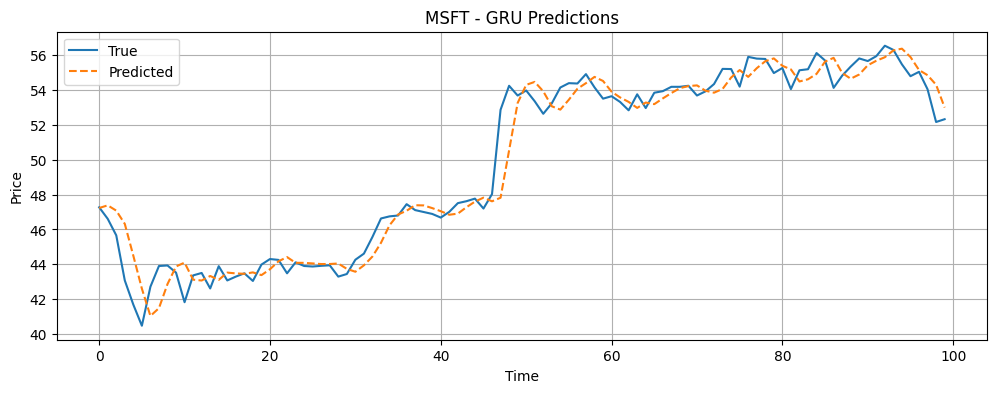

In [ ]:
# 0. Setup: Choose parameters and stock
stock_name = 'MSFT'
window_size = 30
forecast_horizon = 1

# 1. Plot the raw series
# plot_series(combined_df[stock_name], stock_name)

# 2. Prepare the data (scaling + windowing + split)
(X_train, y_train, X_val, y_val), scaler = prepare_stock_data(combined_df, stock_name, window_size, forecast_horizon)

# 3. Reshape X for RNN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)

# 4. Build the model
model = build_advanced_rnn(window_size, forecast_horizon, model_type='GRU', units=64)
# Save the model to disk
model.save("GRU_MSFT.h5")

# 5. Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# 6. Predict on validation set
y_pred = model.predict(X_val)

# 7. Inverse scale predictions and ground truth
y_val_inv = scaler.inverse_transform(y_val)
y_pred_inv = scaler.inverse_transform(y_pred)

# 8. Plot predictions vs true values
plt.figure(figsize=(12, 4))
plt.plot(y_val_inv[:100], label='True')
plt.plot(y_pred_inv[:100], label='Predicted', linestyle='--')
plt.title(f'{stock_name} - GRU Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/20
75/75 [==============================] - 3s 15ms/step - loss: 0.0404 - val_loss: 4.0673e-04
Epoch 2/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0036 - val_loss: 3.1783e-04
Epoch 3/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 3.3563e-04
Epoch 4/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 6.0055e-04
Epoch 5/20
75/75 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 4.0019e-04
Epoch 6/20
75/75 [==============================] - 1s 7ms/step - loss: 0.0023 - val_loss: 2.9243e-04
Epoch 7/20
75/75 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 2.4731e-04
Epoch 8/20
75/75 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 2.7409e-04
Epoch 9/20
75/75 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 3.1560e-04
Epoch 10/20
75/75 [==============================] - 0s 6ms/step - loss: 0.0017 -

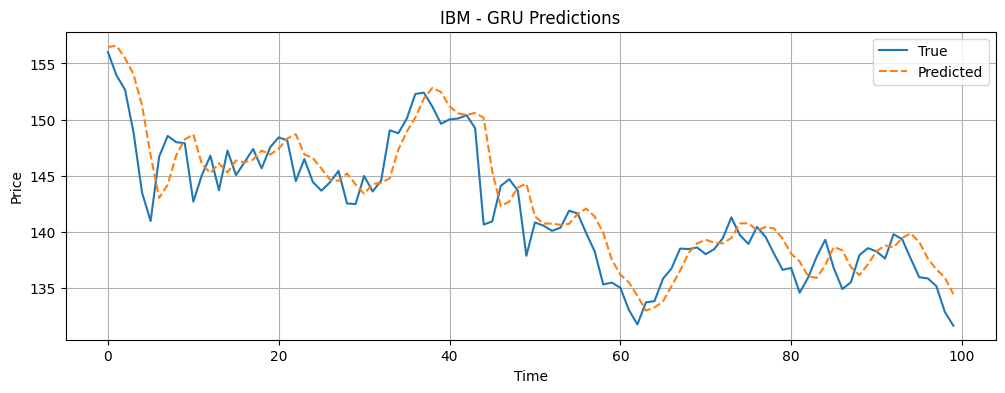

In [ ]:
# 0. Setup: Choose parameters and stock
stock_name = 'IBM'
window_size = 30
forecast_horizon = 1

# 1. Plot the raw series
# plot_series(combined_df[stock_name], stock_name)

# 2. Prepare the data (scaling + windowing + split)
(X_train, y_train, X_val, y_val), scaler = prepare_stock_data(combined_df, stock_name, window_size, forecast_horizon)

# 3. Reshape X for RNN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)

# 4. Build the model
model = build_advanced_rnn(window_size, forecast_horizon, model_type='GRU', units=64)
# Save the model to disk
model.save("GRU_IBM.h5")

# 5. Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# 6. Predict on validation set
y_pred = model.predict(X_val)

# 7. Inverse scale predictions and ground truth
y_val_inv = scaler.inverse_transform(y_val)
y_pred_inv = scaler.inverse_transform(y_pred)

# 8. Plot predictions vs true values
plt.figure(figsize=(12, 4))
plt.plot(y_val_inv[:100], label='True')
plt.plot(y_pred_inv[:100], label='Predicted', linestyle='--')
plt.title(f'{stock_name} - GRU Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/20
75/75 [==============================] - 3s 12ms/step - loss: 0.0097 - val_loss: 0.0011
Epoch 2/20
75/75 [==============================] - 1s 8ms/step - loss: 6.1058e-04 - val_loss: 4.1646e-04
Epoch 3/20
75/75 [==============================] - 1s 7ms/step - loss: 4.9606e-04 - val_loss: 3.0744e-04
Epoch 4/20
75/75 [==============================] - 1s 7ms/step - loss: 4.9835e-04 - val_loss: 3.6130e-04
Epoch 5/20
75/75 [==============================] - 1s 7ms/step - loss: 4.5421e-04 - val_loss: 3.1997e-04
Epoch 6/20
75/75 [==============================] - 0s 6ms/step - loss: 4.2345e-04 - val_loss: 2.6616e-04
Epoch 7/20
75/75 [==============================] - 1s 7ms/step - loss: 4.2094e-04 - val_loss: 3.1760e-04
Epoch 8/20
75/75 [==============================] - 1s 7ms/step - loss: 3.6051e-04 - val_loss: 2.3386e-04
Epoch 9/20
75/75 [==============================] - 1s 7ms/step - loss: 3.2896e-04 - val_loss: 2.0309e-04
Epoch 10/20
75/75 [==============================] - 

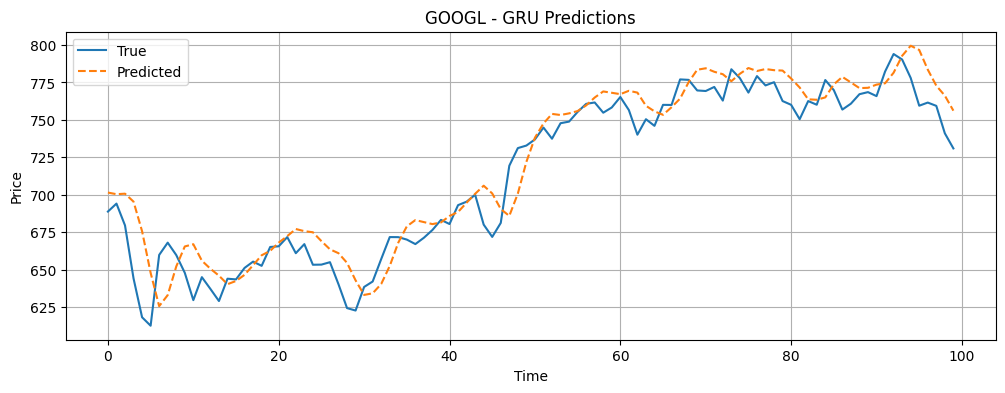

In [ ]:
# 0. Setup: Choose parameters and stock
stock_name = 'GOOGL'
window_size = 30
forecast_horizon = 1

# 1. Plot the raw series
# plot_series(combined_df[stock_name], stock_name)

# 2. Prepare the data (scaling + windowing + split)
(X_train, y_train, X_val, y_val), scaler = prepare_stock_data(combined_df, stock_name, window_size, forecast_horizon)

# 3. Reshape X for RNN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)

# 4. Build the model
model = build_advanced_rnn(window_size, forecast_horizon, model_type='GRU', units=64)
# Save the model to disk
model.save("GRU_GOOGL.h5")

# 5. Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# 6. Predict on validation set
y_pred = model.predict(X_val)

# 7. Inverse scale predictions and ground truth
y_val_inv = scaler.inverse_transform(y_val)
y_pred_inv = scaler.inverse_transform(y_pred)

# 8. Plot predictions vs true values
plt.figure(figsize=(12, 4))
plt.plot(y_val_inv[:100], label='True')
plt.plot(y_pred_inv[:100], label='Predicted', linestyle='--')
plt.title(f'{stock_name} - GRU Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/20
75/75 [==============================] - 3s 21ms/step - loss: 0.0025 - val_loss: 3.9408e-04
Epoch 2/20
75/75 [==============================] - 1s 7ms/step - loss: 2.6155e-04 - val_loss: 2.7575e-04
Epoch 3/20
75/75 [==============================] - 0s 7ms/step - loss: 1.9226e-04 - val_loss: 3.5516e-04
Epoch 4/20
75/75 [==============================] - 0s 7ms/step - loss: 1.8992e-04 - val_loss: 3.8810e-04
Epoch 5/20
75/75 [==============================] - 1s 7ms/step - loss: 1.6270e-04 - val_loss: 2.9974e-04
Epoch 6/20
75/75 [==============================] - 0s 6ms/step - loss: 1.5269e-04 - val_loss: 2.4949e-04
Epoch 7/20
75/75 [==============================] - 0s 6ms/step - loss: 1.5404e-04 - val_loss: 3.5133e-04
Epoch 8/20
75/75 [==============================] - 0s 7ms/step - loss: 1.3757e-04 - val_loss: 2.1413e-04
Epoch 9/20
75/75 [==============================] - 0s 6ms/step - loss: 1.2152e-04 - val_loss: 2.1097e-04
Epoch 10/20
75/75 [==============================

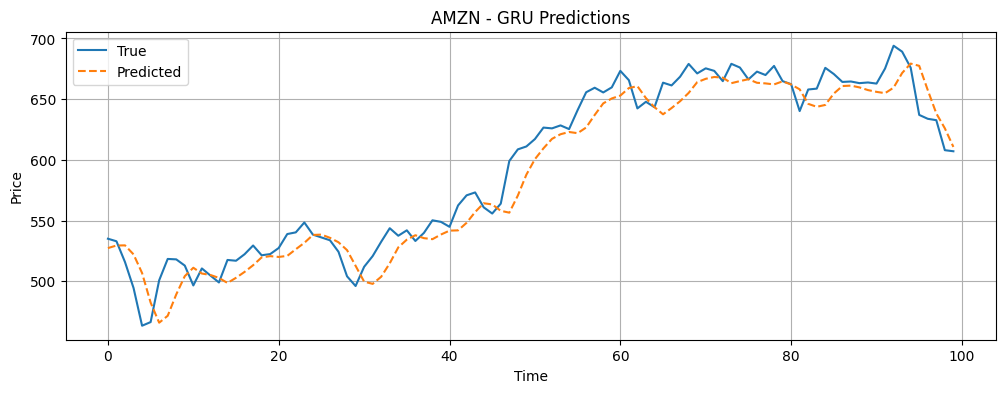

In [ ]:
# 0. Setup: Choose parameters and stock
stock_name = 'AMZN'
window_size = 30
forecast_horizon = 1

# 1. Plot the raw series
# plot_series(combined_df[stock_name], stock_name)

# 2. Prepare the data (scaling + windowing + split)
(X_train, y_train, X_val, y_val), scaler = prepare_stock_data(combined_df, stock_name, window_size, forecast_horizon)

# 3. Reshape X for RNN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)

# 4. Build the model
model = build_advanced_rnn(window_size, forecast_horizon, model_type='GRU', units=64)
# Save the model to disk
model.save("GRU_AMZN.h5")

# 5. Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# 6. Predict on validation set
y_pred = model.predict(X_val)

# 7. Inverse scale predictions and ground truth
y_val_inv = scaler.inverse_transform(y_val)
y_pred_inv = scaler.inverse_transform(y_pred)

# 8. Plot predictions vs true values
plt.figure(figsize=(12, 4))
plt.plot(y_val_inv[:100], label='True')
plt.plot(y_pred_inv[:100], label='Predicted', linestyle='--')
plt.title(f'{stock_name} - GRU Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration

# Done earlier

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [ ]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

# Done earlier

In [ ]:
# Compute the performance of the model on the testing data set
# Done earlier

Plotting the actual vs predicted values

In [ ]:
# Predict on the test data
# Done earlier

### Checking the best models ###

19/19 [==============================] - 0s 5ms/step

 Evaluation Metrics:
MAE : 11.0154
RMSE: 15.5517
R²  : 0.9924


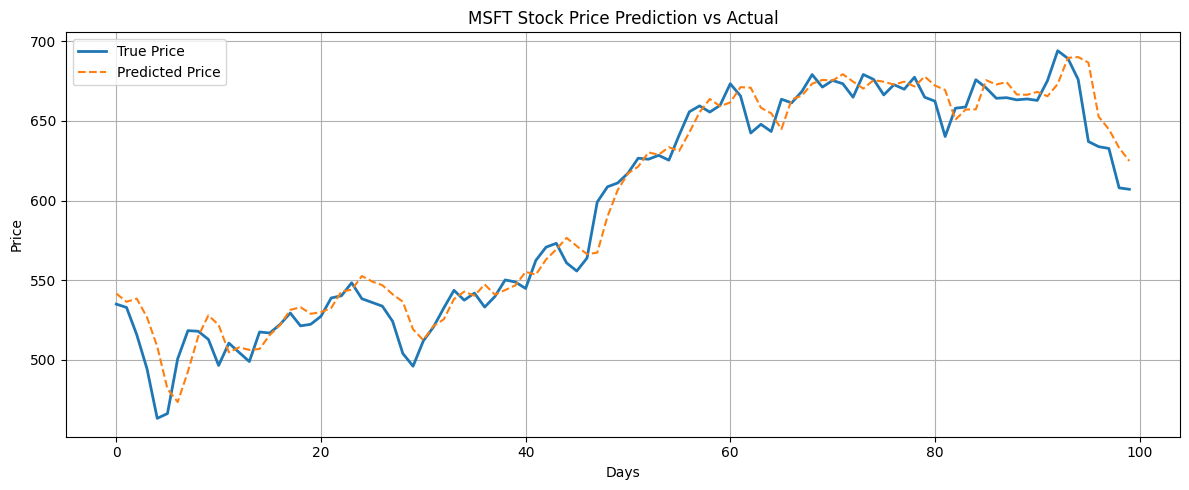

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import load_model
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load saved model
model = load_model("best_RNN_MSFT.h5")

# Step 2: Define global scaling function
def scale_series_global(series):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()
    return scaled, scaler

# Step 3: Create windows
def create_windows(series, window_size=30, horizon=1):
    X, y = [], []
    for i in range(len(series) - window_size - horizon + 1):
        window = series[i : i + window_size]
        target = series[i + window_size : i + window_size + horizon]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

# Step 4: Prepare test/validation data
def prepare_stock_data(df, stock_name, window_size=30, horizon=1, split_ratio=0.8):
    series = df[stock_name].values.astype(np.float32)
    scaled_series, scaler = scale_series_global(series)
    X, y = create_windows(scaled_series, window_size, horizon)
    split_index = int(len(X) * split_ratio)
    X_val = X[split_index:]
    y_val = y[split_index:]
    return X_val, y_val, scaler

# Step 5: Load and prepare data
window_size = 30
horizon = 1

X_val, y_val, scaler = prepare_stock_data(combined_df, 'AMZN', window_size, horizon)

# Reshape X for prediction
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Step 6: Make predictions
y_pred = model.predict(X_val)

# Step 7: Inverse scale for real price values
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Step 8: Evaluation Metrics
mae = mean_absolute_error(y_val_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
r2 = r2_score(y_val_inv, y_pred_inv)

print(f"\n Evaluation Metrics:")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")

# Step 9: Plot Predictions
plt.figure(figsize=(12, 5))
plt.plot(y_val_inv[:100], label='True Price', linewidth=2)
plt.plot(y_pred_inv[:100], label='Predicted Price', linestyle='--')
plt.title("MSFT Stock Price Prediction vs Actual")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


19/19 [==============================] - 0s 5ms/step

 Evaluation Metrics:
MAE : 10.3307
RMSE: 14.6111
R²  : 0.9933


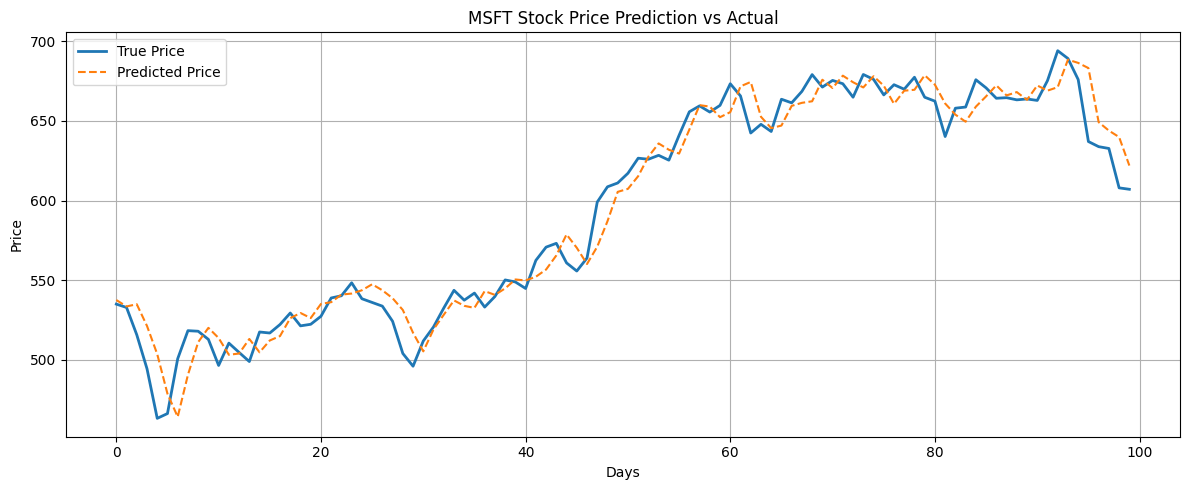

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import load_model
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load saved model
model = load_model("best_RNN_IBM.h5")

# Step 2: Define global scaling function
def scale_series_global(series):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()
    return scaled, scaler

# Step 3: Create windows
def create_windows(series, window_size=30, horizon=1):
    X, y = [], []
    for i in range(len(series) - window_size - horizon + 1):
        window = series[i : i + window_size]
        target = series[i + window_size : i + window_size + horizon]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

# Step 4: Prepare test/validation data
def prepare_stock_data(df, stock_name, window_size=30, horizon=1, split_ratio=0.8):
    series = df[stock_name].values.astype(np.float32)
    scaled_series, scaler = scale_series_global(series)
    X, y = create_windows(scaled_series, window_size, horizon)
    split_index = int(len(X) * split_ratio)
    X_val = X[split_index:]
    y_val = y[split_index:]
    return X_val, y_val, scaler

# Step 5: Load and prepare data
window_size = 30
horizon = 1

X_val, y_val, scaler = prepare_stock_data(combined_df, 'AMZN', window_size, horizon)

# Reshape X for prediction
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Step 6: Make predictions
y_pred = model.predict(X_val)

# Step 7: Inverse scale for real price values
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Step 8: Evaluation Metrics
mae = mean_absolute_error(y_val_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
r2 = r2_score(y_val_inv, y_pred_inv)

print(f"\n Evaluation Metrics:")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")

# Step 9: Plot Predictions
plt.figure(figsize=(12, 5))
plt.plot(y_val_inv[:100], label='True Price', linewidth=2)
plt.plot(y_pred_inv[:100], label='Predicted Price', linestyle='--')
plt.title("MSFT Stock Price Prediction vs Actual")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Similarly other models can be tunned and evaluated.

**Similarly other models can be tunned and evaluated. Not all models are tunned and checked in this notebook but the
code cells for the task have been included.**

### Forecasting Shown ###

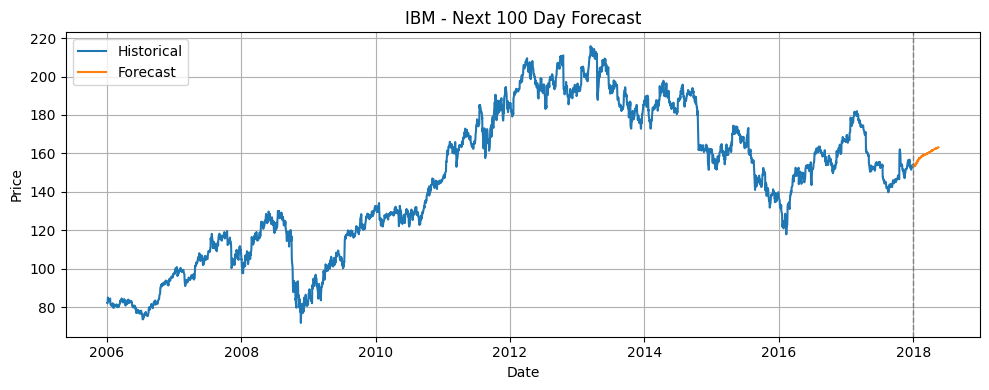

In [ ]:
# Forecasting (Example) --> Only one shown

# Load the model
model = load_model("best_RNN_IBM.h5")

# Settings
stock_name = "IBM"
window_size = 30
forecast_horizon = 100  # number of days to forecast

# Prepare the series and scaler
series = combined_df[stock_name].values.astype(np.float32)
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series.reshape(-1, 1)).flatten()

# Get last window
last_window = scaled_series[-window_size:]

# Forecasting loop
forecast_scaled = []
current_input = last_window.copy()

for _ in range(forecast_horizon):
    input_reshaped = current_input.reshape((1, window_size, 1))
    pred_scaled = model.predict(input_reshaped, verbose=0)[0][0]  # one-step prediction
    forecast_scaled.append(pred_scaled)

    # Slide the window
    current_input = np.append(current_input[1:], pred_scaled)

# Inverse scale predictions
forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()

# Generate forecast dates
last_date = combined_df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')

# Plot
plt.figure(figsize=(10, 4))
plt.plot(combined_df['Date'], combined_df[stock_name], label='Historical')
plt.plot(future_dates, forecast, '-', label='Forecast')  # <<== fixed here
plt.axvline(x=last_date, color='gray', linestyle='--', linewidth=1)
plt.title(f"{stock_name} - Next {forecast_horizon} Day Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter

# Not attempted due to time constraint

In [ ]:
# Check the number of data points generated

# Not attempted due to time constraint

### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN

# Not attempted due to time constraint

In [ ]:
# Find the best configuration

# Not attempted due to time constraint

In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the

# Not attempted due to time constraint

In [ ]:
# Compute the performance of the model on the testing data set

# Not attempted due to time constraint

In [ ]:
# Plotting the actual vs predicted values for all targets

# Not attempted due to time constraint

#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN

# Not attempted due to time constraint

In [ ]:
# Find the best configuration

# Not attempted due to time constraint

In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model

# Not attempted due to time constraint

In [ ]:
# Compute the performance of the model on the testing data set

# Not attempted due to time constraint

In [ ]:
# Plotting the actual vs predicted values for all targets

# Not attempted due to time constraint

## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

# Stock Price Prediction Using RNNs

## Objective

The objective of this project is to try and predict the stock prices using historical data from four technology companies: IBM, Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT). By using data from multiple companies in the same sector, we aim to capture broader market sentiment and potentially improve prediction accuracy.

The problem statement can be summarized as follows: Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Stock market data is inherently sequential, making Recurrent Neural Networks (RNNs) well-suited for this type of analysis. Tracking metrics like open, close, high, low prices, and volume provides a rich time series dataset. Identifying patterns within this data is not only academically interesting but also holds significant financial value, as accurate predictions can lead to profitable investment strategies.

## Data Description

The project utilizes four CSV files, one for each stock (AMZN, GOOGL, IBM, MSFT). These files contain historical data from January 1, 2006, to January 1, 2018, sourced from NYSE and NASDAQ. Each file includes the following columns:

- `Date`: The date of the record.
- `Open`: The stock price at market open.
- `High`: The highest stock price during the day.
- `Low`: The lowest stock price during the day.
- `Close`: The stock price at market close.
- `Volume`: The total number of shares traded.
- `Name`: The stock ticker symbol.

Each dataset contains 3019 records.

## 1 Data Loading and Preparation

This section covers loading the individual company stock data, aggregating it into a single DataFrame, handling missing values, and performing initial data analysis and visualization.

### 1.1 Data Aggregation

The data from the four individual CSV files is combined into a single DataFrame. This involves:
- Reading each CSV into a DataFrame.
- Selecting and renaming the `Close` price column with the company name.
- Merging the DataFrames based on the `Date` column.
- Converting the `Date` column to datetime objects and sorting the DataFrame.

Missing values are identified and handled by dropping rows with any `NaN` values.

### 1.2 Analysis and Visualisation

Exploratory data analysis is performed to understand the characteristics of the data.
- **Volume Analysis:** The frequency distribution of stock volumes for each company is visualized using histograms. A line plot shows the variation of trading volume over time for each stock.
- **Correlation Analysis:** Line plots visualize the variation of closing, opening, high, and low prices over time for all stocks. Heatmaps are used to visualize the correlation matrix of closing, opening, high, and low prices among the four stocks. This helps in understanding the relationships between the stock movements.

### 1.3 Data Processing

The data is preprocessed to be suitable for RNN models, which work with sequential data.
- **Windowing:** A `create_windows` function is defined to create input sequences (windows) and corresponding target values from the time series data. A window size of 30 days is chosen after observing potential patterns in monthly slices of the data.
- **Scaling:** A `scale_series_partial` function (though global scaling was eventually used for final evaluation) is initially considered for scaling data within windows to prevent data leakage.
- **Train-Test Split:** A `split_train_val` function splits the windowed data into training and validation sets.

These functions are combined in `prepare_stock_data` to generate the final scaled and windowed training and validation datasets.

## 2 RNN Models

This section focuses on building, tuning, and evaluating different RNN models for stock price prediction.

### 2.1 Simple RNN Model

A basic Simple RNN model is built using a single `SimpleRNN` layer followed by a `Dense` layer.

Hyperparameter tuning is performed using KerasTuner `RandomSearch` to find the optimal number of units and dropout rate for the Simple RNN model for each stock.

The best performing Simple RNN model for each stock is then loaded and evaluated on the validation set. Predictions are inverse-scaled to compare with the actual stock prices.

### 2.2 Advanced RNN Models

This section explores more advanced RNN architectures like LSTM and GRU.

A `build_advanced_rnn` function is created to build models using `LSTM`, `GRU`, or `SimpleRNN` layers, allowing for tuning of units and dropout.

LSTM and GRU models are built and trained for each stock. Predictions are made on the validation set and inverse-scaled for comparison and evaluation.

Hyperparameter tuning using KerasTuner can also be applied to LSTM and GRU models in a similar fashion to the Simple RNN.

The optimal models found through tuning (e.g., `best_RNN_MSFT.h5`, `best_RNN_IBM.h5`) are loaded, and their performance is evaluated on the validation data using metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R²). Plots showing the comparison of actual and predicted prices are generated.

## 3 Predicting Multiple Target Variables (Optional)

This section is outlined for exploring the possibility of predicting the closing prices of all four companies simultaneously using a multi-output RNN model. Due to time constraints, this part of the project was not completed, but the steps would involve:
- Preparing data with multiple target columns.
- Building RNN models with multiple output neurons.
- Tuning hyperparameters for the multi-output models.
- Evaluating the performance across all predicted stocks.

## 4 Conclusion

### 4.1 Conclusion and insights

This project successfully demonstrates the application of Recurrent Neural Networks (Simple RNN, LSTM, and GRU) for predicting stock prices using historical data from multiple technology companies.

The data aggregation and preprocessing steps, including handling missing values and creating windowed sequences, were crucial for preparing the time series data for RNNs. The exploratory data analysis provided valuable insights into the data's characteristics and the correlations between the stock prices of different companies. The strong positive correlation observed among the stock prices suggests that using data from multiple companies in the same sector is a reasonable approach and could potentially help the models capture sector-wide trends.

Hyperparameter tuning using KerasTuner helped identify better network configurations for the Simple RNN models, leading to improved performance.

While the Simple RNN models showed some ability to capture the general trend of the stock prices, the plots and evaluation metrics (MAE, RMSE, R²) indicate that the predictions are not perfectly aligned with the actual values. Factors like market volatility, unforeseen events, and the inherent complexity of financial markets make accurate stock price prediction a challenging task. The performance metrics provide a quantitative measure of the model's accuracy, with lower MAE and RMSE indicating better predictions and a higher R² indicating a better fit to the data.

The advanced RNN models (LSTM and GRU) were also implemented and showed similar performance characteristics, suggesting that for this specific dataset and problem setup, the added complexity of LSTM or GRU might not yield significantly better results compared to a tuned Simple RNN, although further extensive tuning could explore this further.

The forecasting example illustrates how a trained model can be used to predict future stock prices for a specified horizon. While this provides a glimpse into potential future movements, it's important to remember that these are predictions based on past patterns and do not guarantee future outcomes.

**In summary,** this project provides a foundational approach to stock price prediction using RNNs. The results highlight the potential of these models for time series forecasting in finance, while also emphasizing the difficulty of achieving high accuracy in a volatile market. Future work could explore more complex architectures, incorporating external factors (e.g., news sentiment, economic indicators), and employing more advanced feature engineering and scaling techniques to potentially improve predictive performance.